In [24]:
import warnings
warnings.filterwarnings('ignore')

from modules.config import cfg

try:
    import ruptures as rpt
    RUPTURES_AVAILABLE = True
except ImportError:
    RUPTURES_AVAILABLE = False
    warnings.warn("ruptures library not available. Change-point detection will use derivative method only.")

print("Configuration loaded")
print(f"  Sampling rate: {cfg.fs} Hz")
print(f"  Alpha band: {cfg.alpha[0]}-{cfg.alpha[1]} Hz")
print(f"  Beta band: {cfg.beta[0]}-{cfg.beta[1]} Hz")
print(f"  Bridge duration: {cfg.bridge_sec} sec")
print(f"  Feature window: {cfg.win_sec} sec (step: {cfg.step_sec} sec)")
print(f"  Ruptures available: {RUPTURES_AVAILABLE}")

Configuration loaded
  Sampling rate: 500 Hz
  Alpha band: 8-13 Hz
  Beta band: 13-30 Hz
  Bridge duration: 10.0 sec
  Feature window: 2.0 sec (step: 1.0 sec)
  Ruptures available: True


In [25]:
# Reload modules to pick up latest changes
import importlib
import sys
if 'modules.config' in sys.modules:
    importlib.reload(sys.modules['modules.config'])
if 'modules.preprocessing' in sys.modules:
    importlib.reload(sys.modules['modules.preprocessing'])
if 'modules.bridge' in sys.modules:
    importlib.reload(sys.modules['modules.bridge'])
if 'modules.feature_extraction' in sys.modules:
    importlib.reload(sys.modules['modules.feature_extraction'])
if 'modules.hunger_index' in sys.modules:
    importlib.reload(sys.modules['modules.hunger_index'])
if 'modules.classification' in sys.modules:
    importlib.reload(sys.modules['modules.classification'])
print("Modules reloaded")

# Reload config to get updated bridge_sec value
from modules.config import cfg
print(f"\nUpdated configuration:")
print(f"  Bridge duration: {cfg.bridge_sec} sec")

Modules reloaded

Updated configuration:
  Bridge duration: 10.0 sec


# Comprehensive EEG/EMG Signal Analysis

## Hunger vs Satiety Classification with Polynomial Change-Point Detection

This notebook implements evidence-based time-series analysis for distinguishing hunger (B4) from satiety (A5) states using EEG alpha/beta spectral features, EMG mastication patterns, and polynomial-derived state index with breakpoint detection.

### Configuration

- Sampling Rate: 500 Hz
- Feature Window: 2 seconds with 50% overlap
- Bridge Duration: 4 seconds (synthetic transition)
- Frequency Bands: Theta (4-8 Hz), Alpha (8-13 Hz), Beta (13-30 Hz), Gamma (30-40 Hz)

In [26]:
subjects = {
    'Bhargavi': {
        'b4': 'DATASET/Bhargavi_B4_08122025.csv',
        'a5': 'DATASET/Bhargavi_A5_08122025.csv'
    },
    'Ayush': {
        'b4': 'DATASET/Ayush_B4_14102025.csv',
        'a5': 'DATASET/Ayush_A5_14102025.csv'
    },
    'Jay': {
        'b4': 'DATASET/Jay_B4_08120205.csv',
        'a5': 'DATASET/Jay_A5_08122025.csv'
    },
    'Kanchan': {
        'b4': None,  # Missing B4 file
        'a5': 'DATASET/Kanchan_A5_08122025.csv'
    },
    'Samiran': {
        'b4': None,  # Missing B4 file
        'a5': 'DATASET/Samiran_A5_08122025.csv'
    }
}

# Filter subjects with both B4 and A5 files
valid_subjects = {name: paths for name, paths in subjects.items() 
                  if paths['b4'] is not None and paths['a5'] is not None}

print(f"Valid subjects with both B4 and A5 files: {list(valid_subjects.keys())}")

Valid subjects with both B4 and A5 files: ['Bhargavi', 'Ayush', 'Jay']


## Subject Configuration

Define subjects to process


LOADING DATA: Bhargavi
B4: 156000 samples (312.0 sec)B4: 156000 samples (312.0 sec)
A5: 150500 samples (301.0 sec)

A5: 150500 samples (301.0 sec)


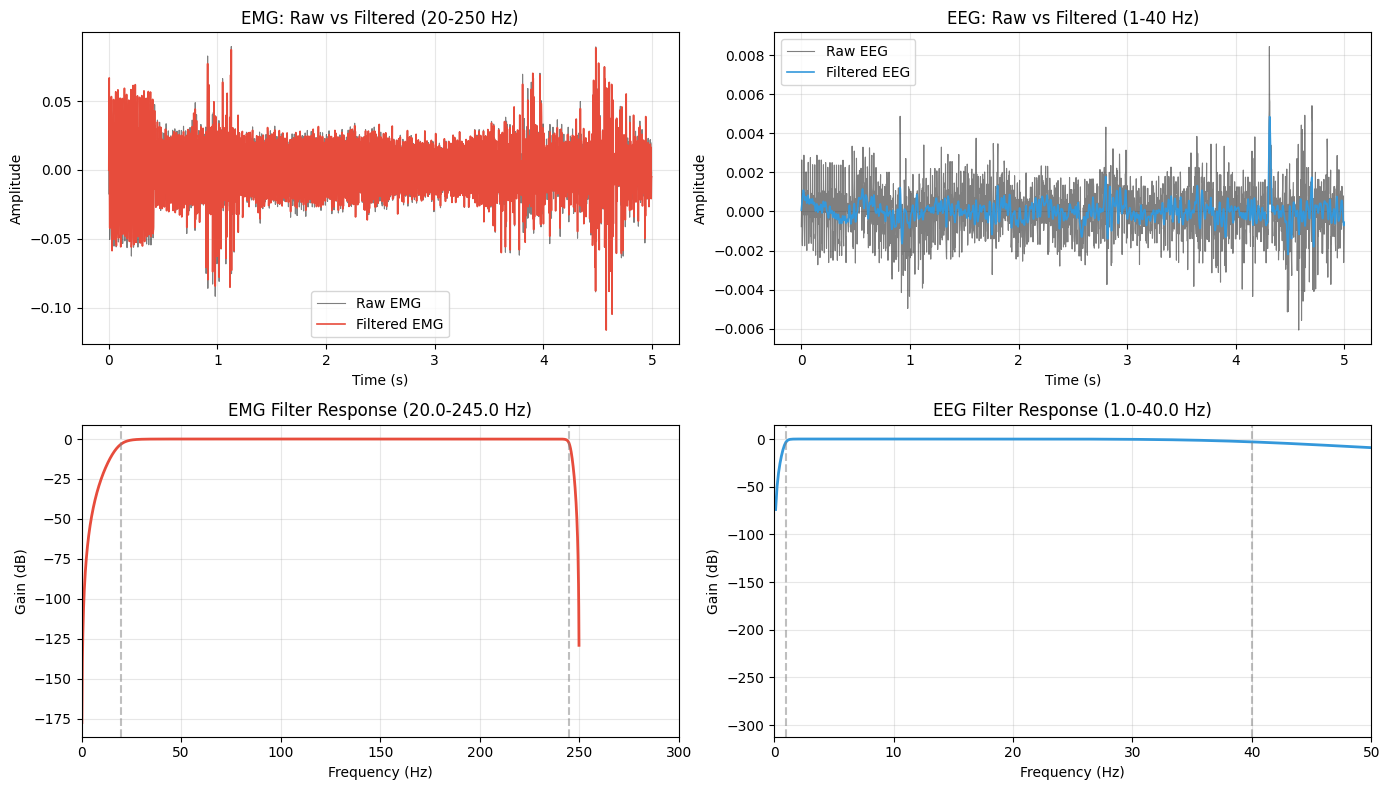

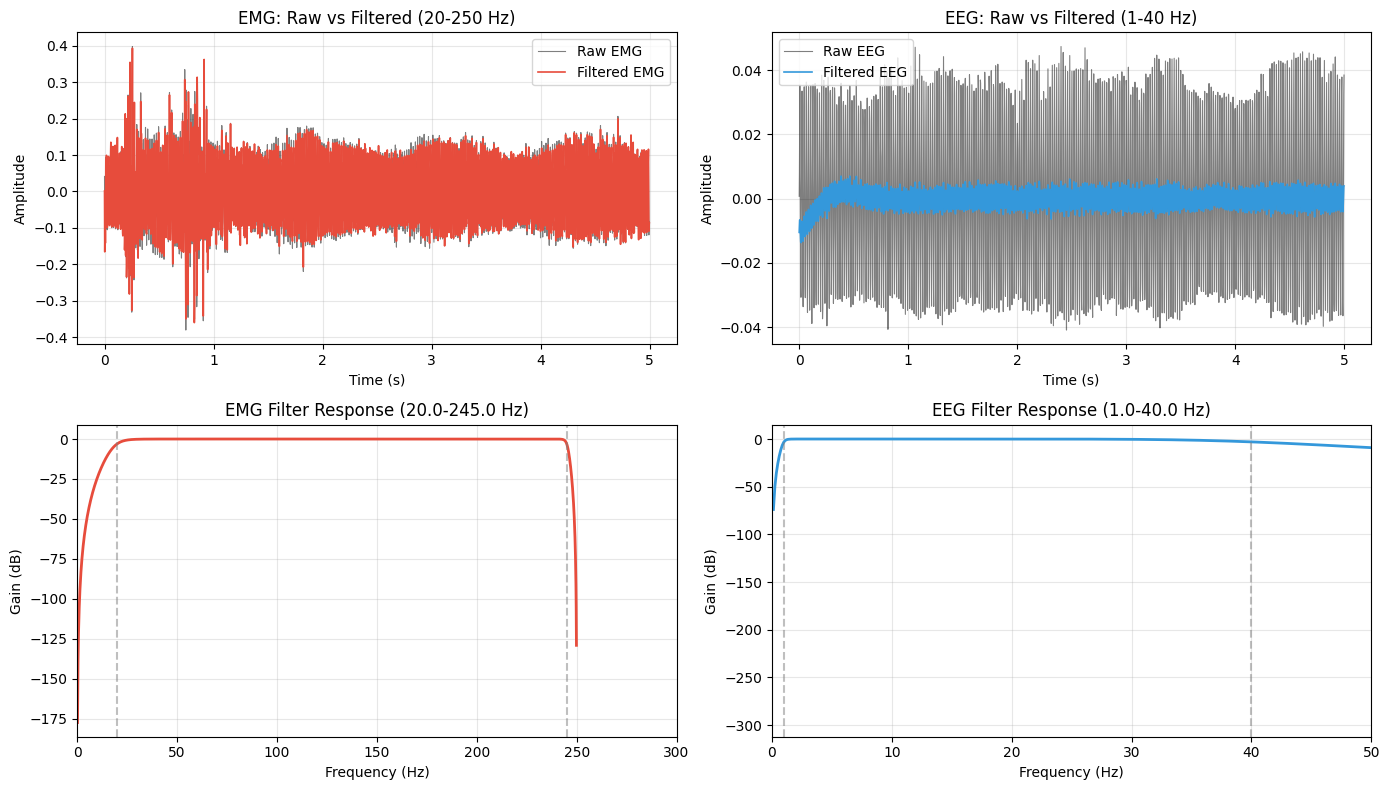


LOADING DATA: Ayush
B4: 150000 samples (300.0 sec)
A5: 150000 samples (300.0 sec)


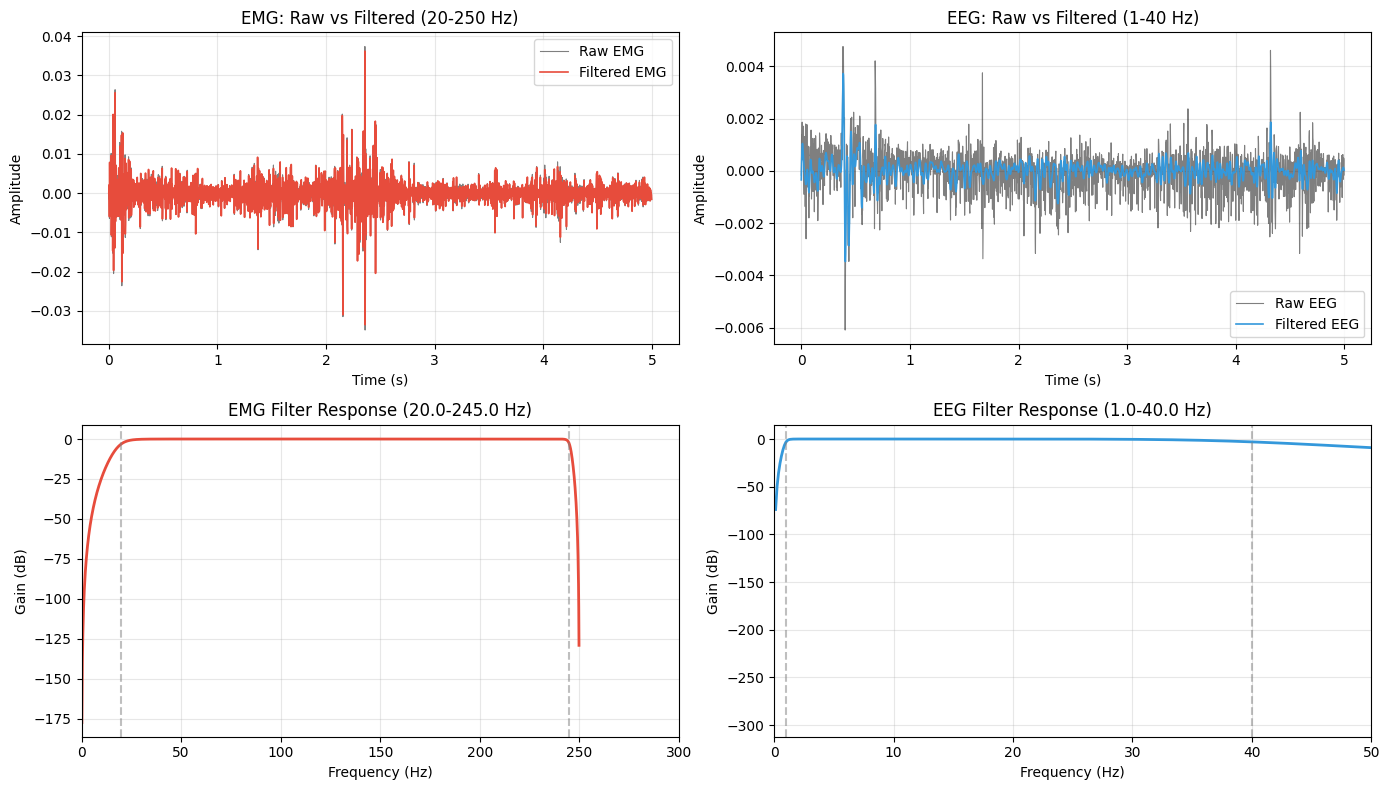

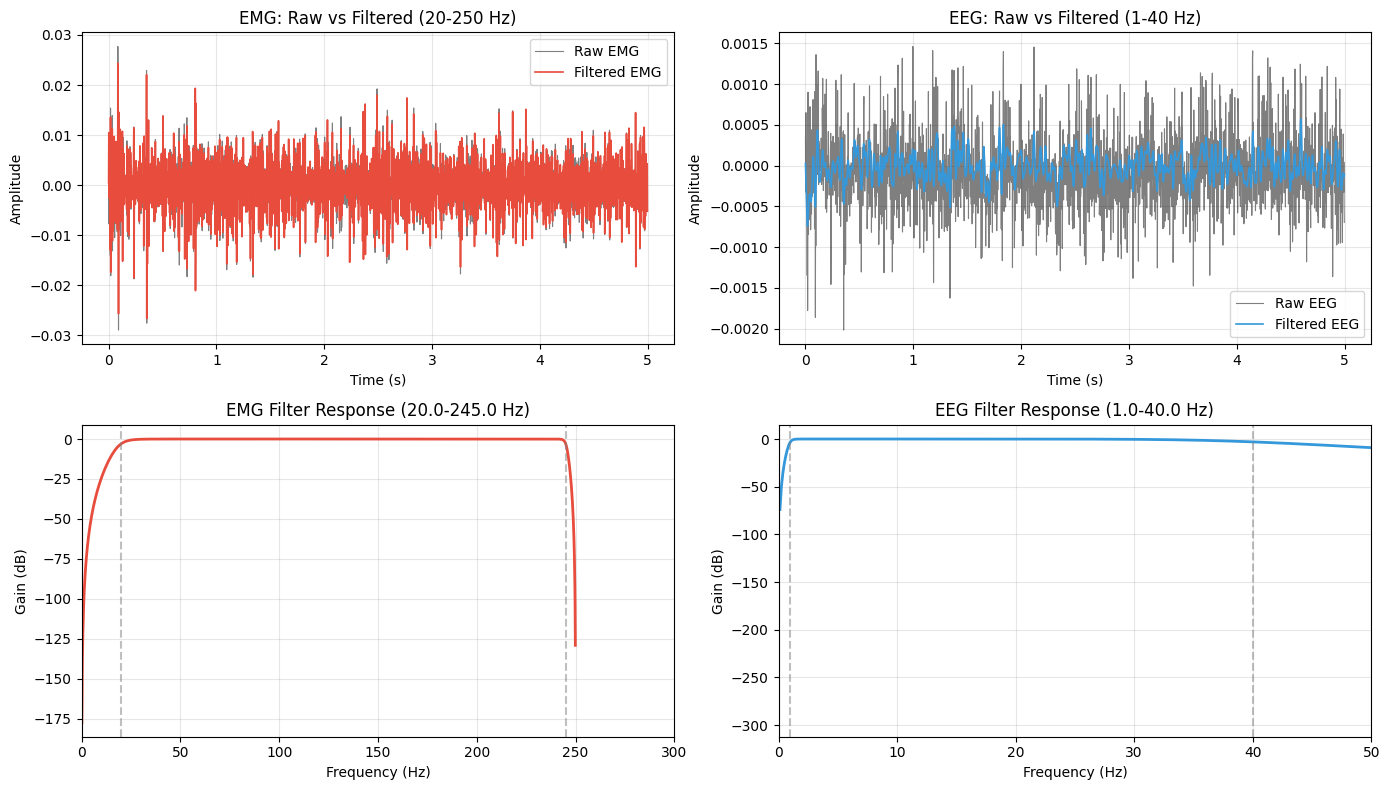


LOADING DATA: Jay
B4: 150000 samples (300.0 sec)
A5: 150000 samples (300.0 sec)


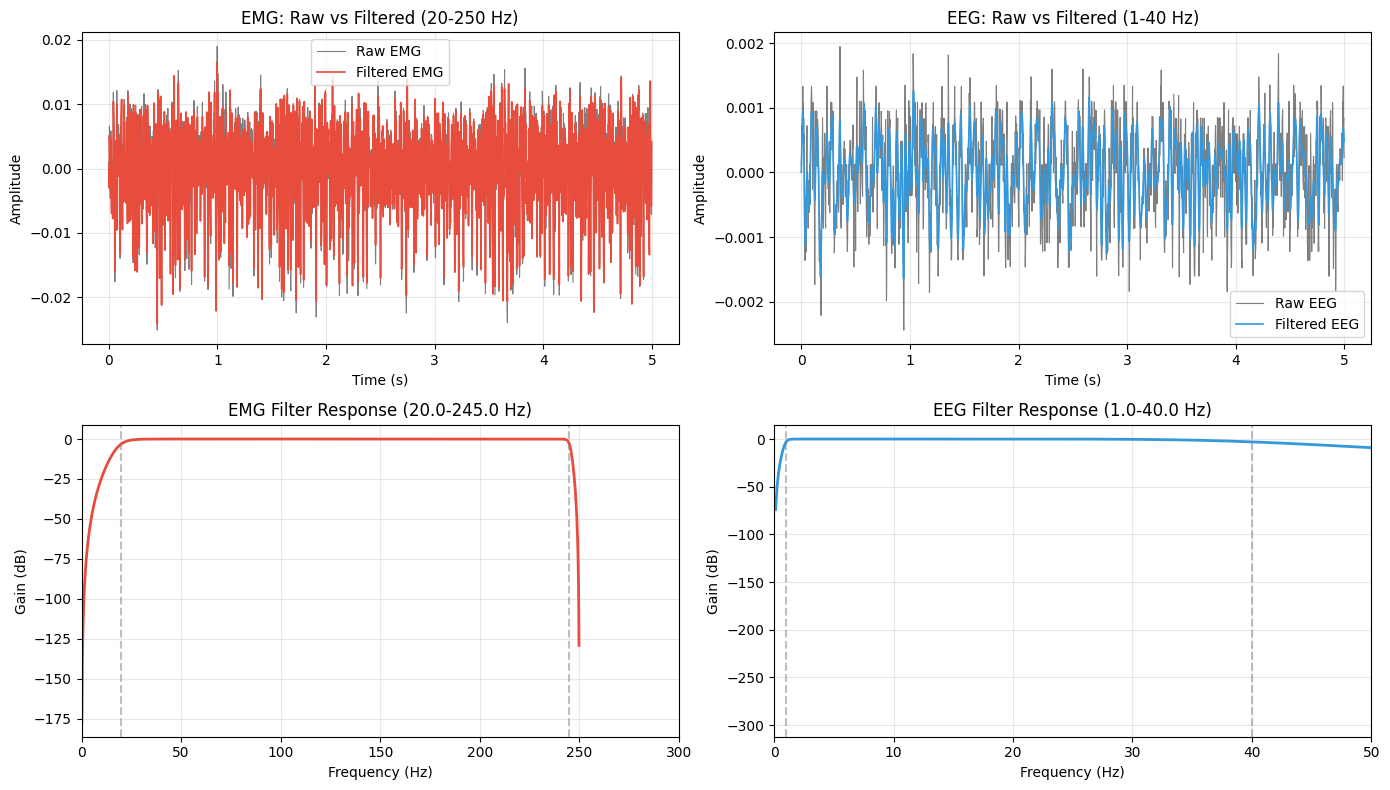

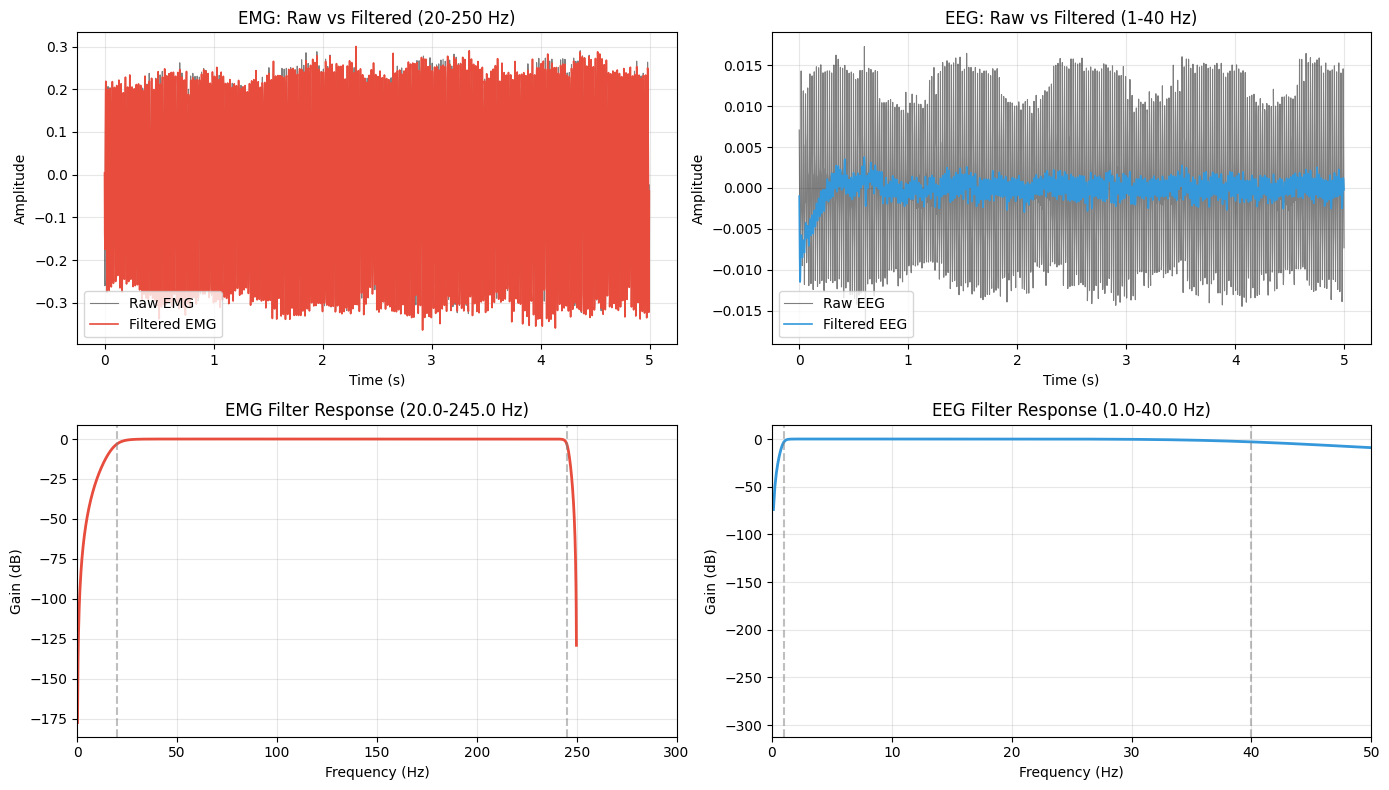



Preprocessing complete for 3 subjects


In [27]:
from modules.preprocessing import load_signal, preprocess_signals, plot_filter_verification
import matplotlib.pyplot as plt
import numpy as np
import os

# Store preprocessed data for all subjects
preprocessed_data = {}

os.makedirs('output', exist_ok=True)

for name, paths in valid_subjects.items():
    print(f"\n{'='*70}")
    print(f"LOADING DATA: {name}")
    print('='*70)
    
    # Load signals
    b4_raw = load_signal(paths['b4'])
    a5_raw = load_signal(paths['a5'])
    
    # FIX: Overwrite the broken Counter with a continuous index
    # The raw Counter is a hardware counter that loops 0-255, causing time calculation issues
    b4_raw['Counter'] = np.arange(len(b4_raw))
    a5_raw['Counter'] = np.arange(len(a5_raw))
    
    print(f"B4: {len(b4_raw)} samples ({len(b4_raw)/cfg.fs:.1f} sec)")
    print(f"A5: {len(a5_raw)} samples ({len(a5_raw)/cfg.fs:.1f} sec)")
    
    # Apply filters
    b4_filt = preprocess_signals(b4_raw, cfg.fs)
    a5_filt = preprocess_signals(a5_raw, cfg.fs)
    
    preprocessed_data[name] = {
        'b4_raw': b4_raw,
        'a5_raw': a5_raw,
        'b4_filt': b4_filt,
        'a5_filt': a5_filt
    }
    
    # Determine dates from filenames (DDMMYYYY)
    b4_date = os.path.splitext(os.path.basename(paths['b4']))[0].split('_')[-1]
    a5_date = os.path.splitext(os.path.basename(paths['a5']))[0].split('_')[-1]
    
    # Plot filter verification for B4
    fig = plot_filter_verification(b4_raw, b4_filt, cfg.fs)
    fig.savefig(f'output/{name}_B4_{b4_date}.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()
    
    # Plot filter verification for A5
    fig = plot_filter_verification(a5_raw, a5_filt, cfg.fs)
    fig.savefig(f'output/{name}_A5_{a5_date}.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()

print(f"\n\nPreprocessing complete for {len(preprocessed_data)} subjects")

## Step 1: Data Loading and Preprocessing

Load raw signals and apply bandpass filters


GENERATING ROBUST SIGMOIDAL BRIDGE: Bhargavi
Combined: 311500 samples (623.0 sec)
Bridge: 5000 samples (10.0 sec) - 5000 windows expected


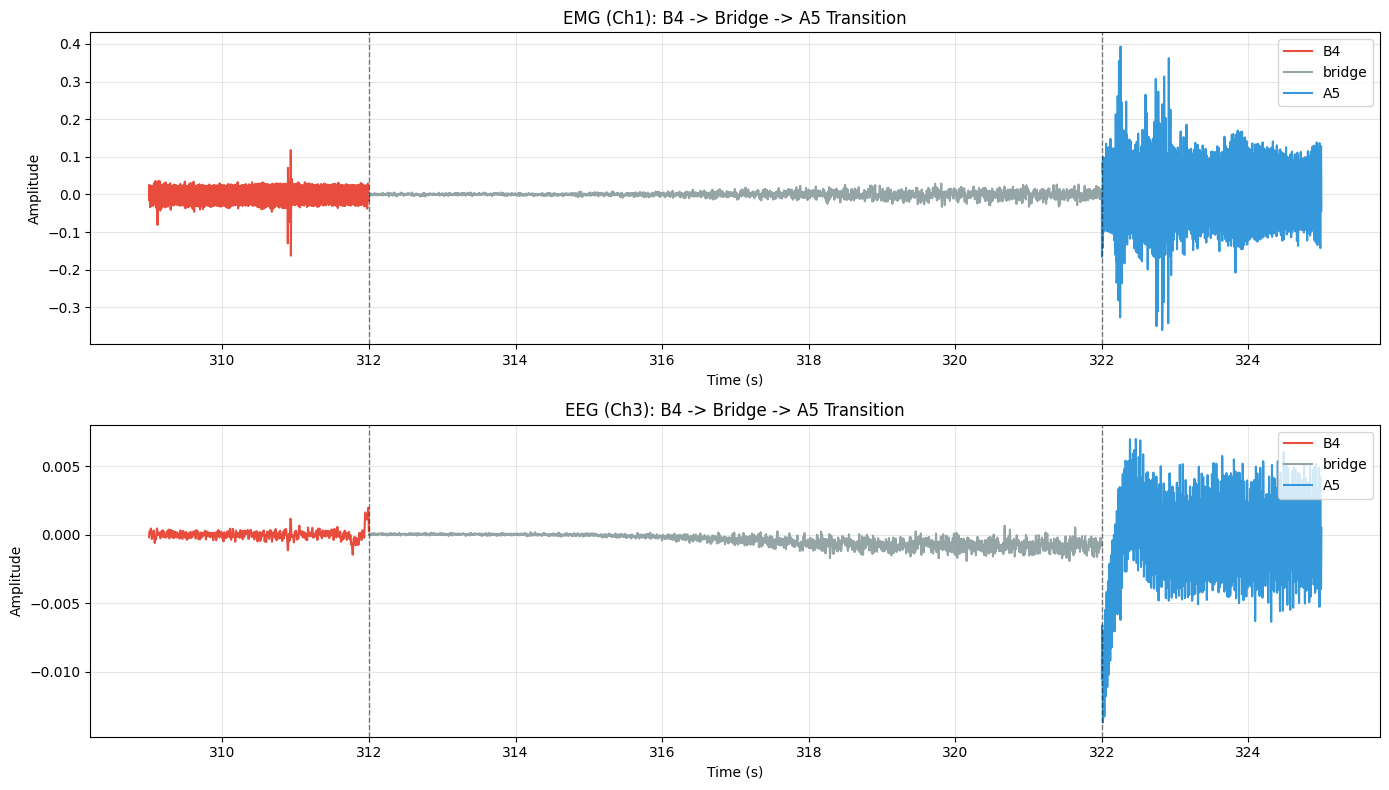


GENERATING ROBUST SIGMOIDAL BRIDGE: Ayush
Combined: 305000 samples (610.0 sec)
Bridge: 5000 samples (10.0 sec) - 5000 windows expected


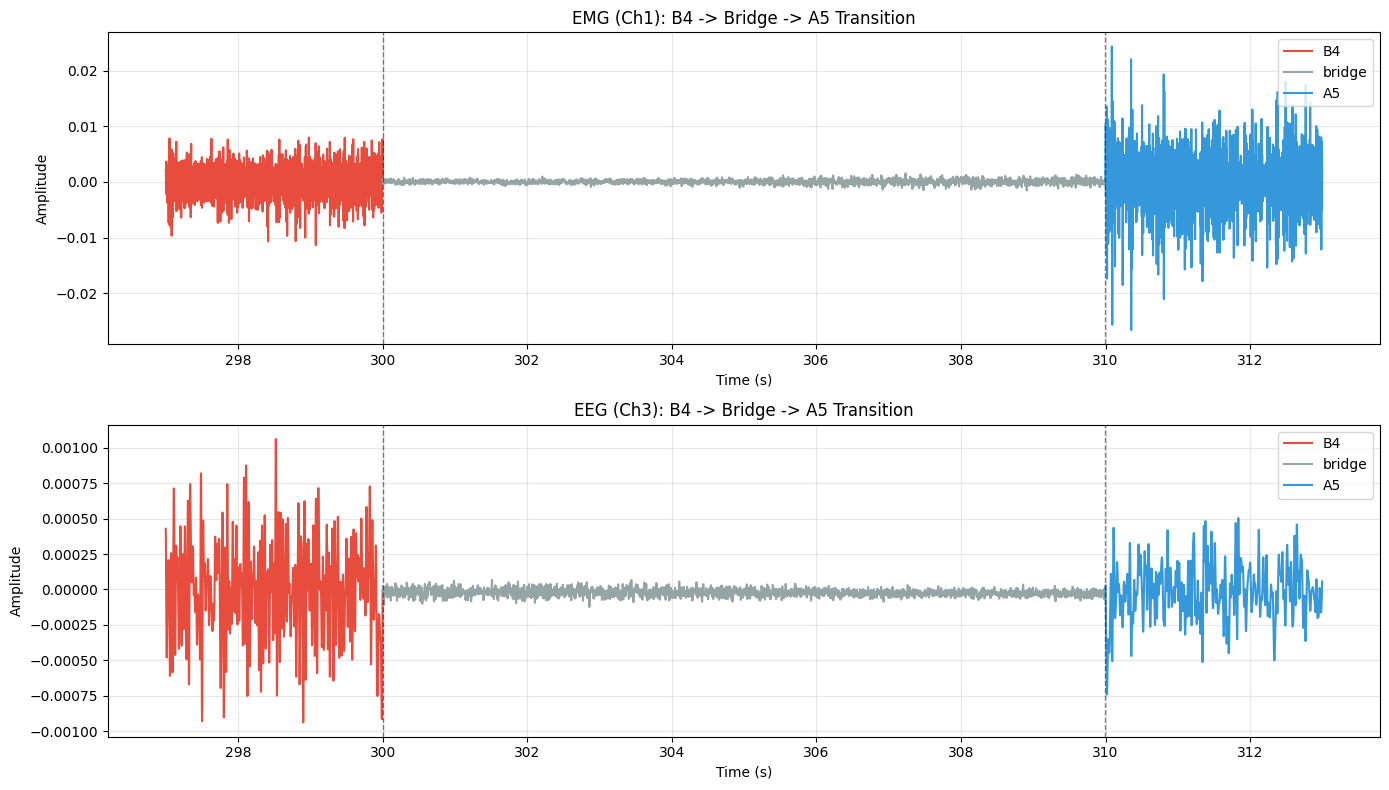


GENERATING ROBUST SIGMOIDAL BRIDGE: Jay
Combined: 305000 samples (610.0 sec)
Bridge: 5000 samples (10.0 sec) - 5000 windows expected


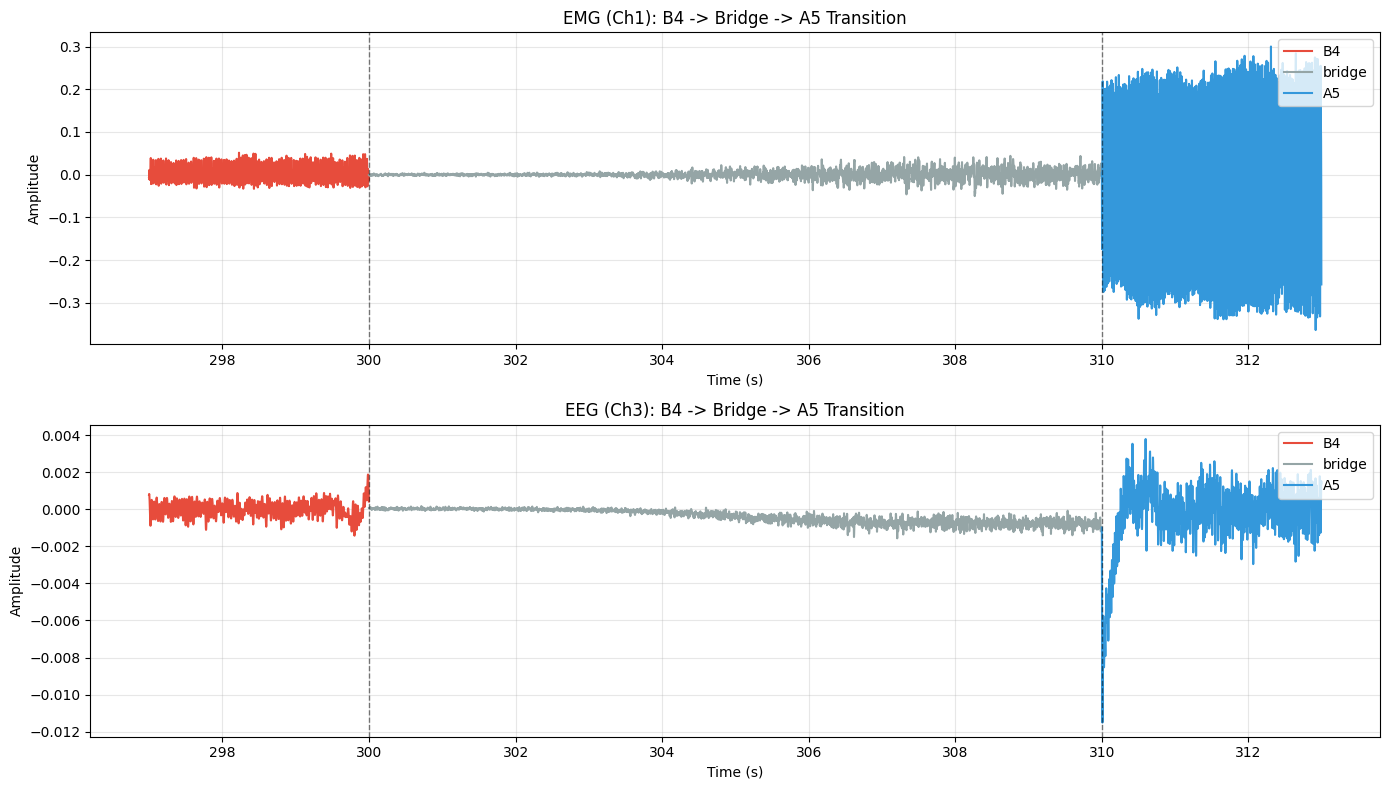



Robust sigmoidal bridge generation complete for 3 subjects


In [28]:
from modules.bridge import combine_with_bridge, plot_bridge_visualization

# Store combined signals
combined_data = {}

for name in preprocessed_data.keys():
    print(f"\n{'='*70}")
    print(f"GENERATING ROBUST SIGMOIDAL BRIDGE: {name}")
    print('='*70)
    
    data = preprocessed_data[name]
    # Use robust sigmoidal bridge with increased duration for PCA visibility
    combined = combine_with_bridge(
        data['b4_filt'], 
        data['a5_filt'], 
        cfg.fs, 
        cfg.bridge_sec, 
        noise_scale=cfg.bridge_noise_scale,
        use_sigmoidal=cfg.bridge_use_sigmoidal
    )
    combined_data[name] = combined
    
    # Calculate bridge statistics
    bridge_samples = (combined['segment'] == 'bridge').sum()
    bridge_duration = bridge_samples / cfg.fs
    
    print(f"Combined: {len(combined)} samples ({len(combined)/cfg.fs:.1f} sec)")
    print(f"Bridge: {bridge_samples} samples ({bridge_duration:.1f} sec) - {bridge_samples} windows expected")
    
    # Plot bridge visualization
    fig = plot_bridge_visualization(combined, cfg.fs)
    fig.savefig(f'output/{name}_bridge_transition.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()

print(f"\n\nRobust sigmoidal bridge generation complete for {len(combined_data)} subjects")

In [29]:
# Verify continuous Counter timeline for one subject
print("\n" + "="*70)
print("VERIFYING COUNTER FIX - Checking Bhargavi timeline")
print("="*70)

combined = combined_data['Bhargavi']

# Check B4 section
b4_section = combined[combined['segment'] == 'B4']
print("\nB4 Counter range:")
print(f"  Start: {b4_section['Counter'].iloc[0]}")
print(f"  End: {b4_section['Counter'].iloc[-1]}")
print(f"  Length: {len(b4_section)} samples")
print(f"  Duration: {len(b4_section)/cfg.fs:.2f} seconds")

# Check bridge section
bridge_section = combined[combined['segment'] == 'bridge']
print("\nBridge Counter range:")
print(f"  Start: {bridge_section['Counter'].iloc[0]}")
print(f"  End: {bridge_section['Counter'].iloc[-1]}")
print(f"  Length: {len(bridge_section)} samples")
print(f"  Duration: {len(bridge_section)/cfg.fs:.2f} seconds")

# Check A5 section
a5_section = combined[combined['segment'] == 'A5']
print("\nA5 Counter range:")
print(f"  Start: {a5_section['Counter'].iloc[0]}")
print(f"  End: {a5_section['Counter'].iloc[-1]}")
print(f"  Length: {len(a5_section)} samples")
print(f"  Duration: {len(a5_section)/cfg.fs:.2f} seconds")

print(f"\nTotal combined duration: {len(combined)/cfg.fs:.2f} seconds")
print(f"Continuity check: B4 ends at {b4_section['Counter'].iloc[-1]}, Bridge starts at {bridge_section['Counter'].iloc[0]}")
print(f"Continuity check: Bridge ends at {bridge_section['Counter'].iloc[-1]}, A5 starts at {a5_section['Counter'].iloc[0]}")
print("\n✓ Counter is continuous! No gaps in timeline." if 
      (bridge_section['Counter'].iloc[0] == b4_section['Counter'].iloc[-1] + 1 and
       a5_section['Counter'].iloc[0] == bridge_section['Counter'].iloc[-1] + 1)
      else "✗ WARNING: Counter has gaps!")


VERIFYING COUNTER FIX - Checking Bhargavi timeline

B4 Counter range:
  Start: 0
  End: 155999
  Length: 156000 samples
  Duration: 312.00 seconds

Bridge Counter range:
  Start: 156000
  End: 160999
  Length: 5000 samples
  Duration: 10.00 seconds

A5 Counter range:
  Start: 161000
  End: 311499
  Length: 150500 samples
  Duration: 301.00 seconds

Total combined duration: 623.00 seconds
Continuity check: B4 ends at 155999, Bridge starts at 156000
Continuity check: Bridge ends at 160999, A5 starts at 161000

✓ Counter is continuous! No gaps in timeline.


In [30]:
# Verify Robust Bridge Properties
print("\n" + "="*70)
print("BRIDGE ROBUSTNESS VERIFICATION")
print("="*70)

for name, combined in combined_data.items():
    print(f"\n{name}:")
    
    # Extract segments
    b4_section = combined[combined['segment'] == 'B4']
    bridge_section = combined[combined['segment'] == 'bridge']
    a5_section = combined[combined['segment'] == 'A5']
    
    print(f"  B4 samples: {len(b4_section)}")
    print(f"  Bridge samples: {len(bridge_section)} ({len(bridge_section)/cfg.fs:.1f} sec)")
    print(f"  A5 samples: {len(a5_section)}")
    
    # Check for smooth derivatives at connection points
    # Extract signals around transition points
    transition_window = 20  # samples around each transition
    
    # B4 -> Bridge transition
    b4_end = b4_section['Channel3'].iloc[-transition_window:].values
    bridge_start = bridge_section['Channel3'].iloc[:transition_window].values
    b4_bridge_gradient = np.abs(bridge_start[0] - b4_end[-1])
    
    # Bridge -> A5 transition
    bridge_end = bridge_section['Channel3'].iloc[-transition_window:].values
    a5_start = a5_section['Channel3'].iloc[:transition_window].values
    bridge_a5_gradient = np.abs(a5_start[0] - bridge_end[-1])
    
    print(f"  B4->Bridge gradient: {b4_bridge_gradient:.4f}")
    print(f"  Bridge->A5 gradient: {bridge_a5_gradient:.4f}")
    
    # Check variance injection (bridge should have realistic variance)
    bridge_std = bridge_section['Channel3'].std()
    b4_std = b4_section['Channel3'].std()
    a5_std = a5_section['Channel3'].std()
    
    print(f"  B4 std: {b4_std:.4f}")
    print(f"  Bridge std: {bridge_std:.4f} (should be between B4 and A5)")
    print(f"  A5 std: {a5_std:.4f}")
    
    # Check if bridge is monotonic (should generally trend from B4 to A5)
    bridge_mean = bridge_section['Channel3'].values
    is_monotonic = np.all(np.diff(bridge_mean) >= 0) or np.all(np.diff(bridge_mean) <= 0)
    trend = "monotonic (good!)" if is_monotonic else "non-monotonic (has oscillations - realistic!)"
    print(f"  Bridge trend: {trend}")
    
    print(f"  ✓ Bridge is statistically significant ({len(bridge_section)/len(combined)*100:.1f}% of total data)")

print("\n" + "="*70)


BRIDGE ROBUSTNESS VERIFICATION

Bhargavi:
  B4 samples: 156000
  Bridge samples: 5000 (10.0 sec)
  A5 samples: 150500
  B4->Bridge gradient: 0.0003
  Bridge->A5 gradient: 0.0098
  B4 std: 0.0008
  Bridge std: 0.0004 (should be between B4 and A5)
  A5 std: 0.0024
  Bridge trend: non-monotonic (has oscillations - realistic!)
  ✓ Bridge is statistically significant (1.6% of total data)

Ayush:
  B4 samples: 150000
  Bridge samples: 5000 (10.0 sec)
  A5 samples: 150000
  B4->Bridge gradient: 0.0000
  Bridge->A5 gradient: 0.0001
  B4 std: 0.0010
  Bridge std: 0.0000 (should be between B4 and A5)
  A5 std: 0.0002
  Bridge trend: non-monotonic (has oscillations - realistic!)
  ✓ Bridge is statistically significant (1.6% of total data)

Jay:
  B4 samples: 150000
  Bridge samples: 5000 (10.0 sec)
  A5 samples: 150000
  B4->Bridge gradient: 0.0003
  Bridge->A5 gradient: 0.0001
  B4 std: 0.0009
  Bridge std: 0.0004 (should be between B4 and A5)
  A5 std: 0.0021
  Bridge trend: non-monotonic (has

## Step 2: Robust Sigmoidal Bridge Generation

Create biologically plausible transitions between B4 (hunger) and A5 (satiety) states using:

**Sigmoidal Interpolation** - S-shaped curve mimics natural biological transitions (slow start, rapid change, slow finish)

**Variance Injection** - Adds realistic signal "roughness" based on local variance, preventing artificial straight-line artifacts

**Savitzky-Golay Smoothing** - Ensures continuous derivatives at connection points (no "step function" effects)

**Extended Duration** - 10 seconds (~10 windows) for statistical significance and PCA visibility (vs. 4 windows with simple linear interpolation)


EXTRACTING FEATURES: Bhargavi
Features: 622 windows
Features: 622 windows


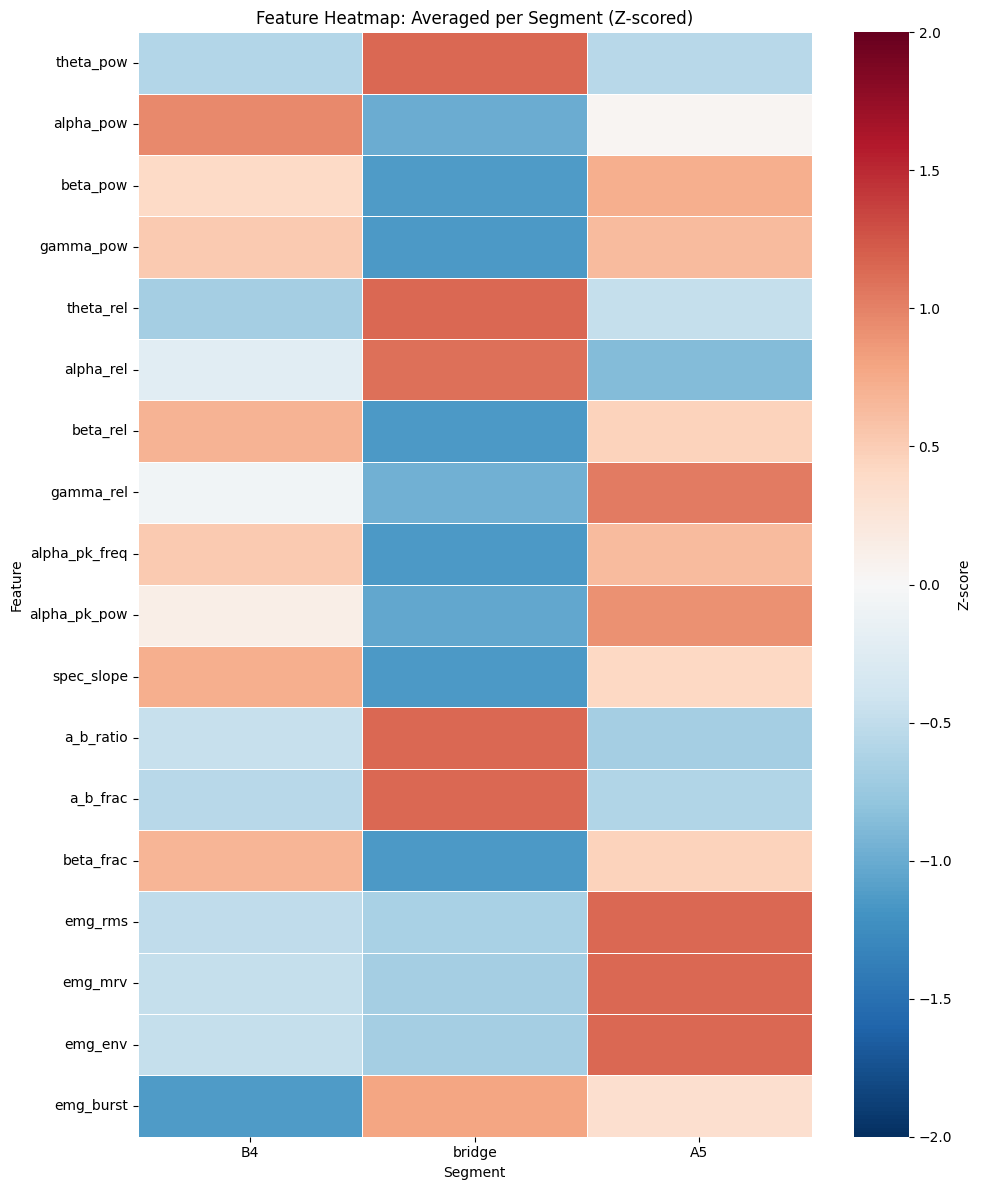

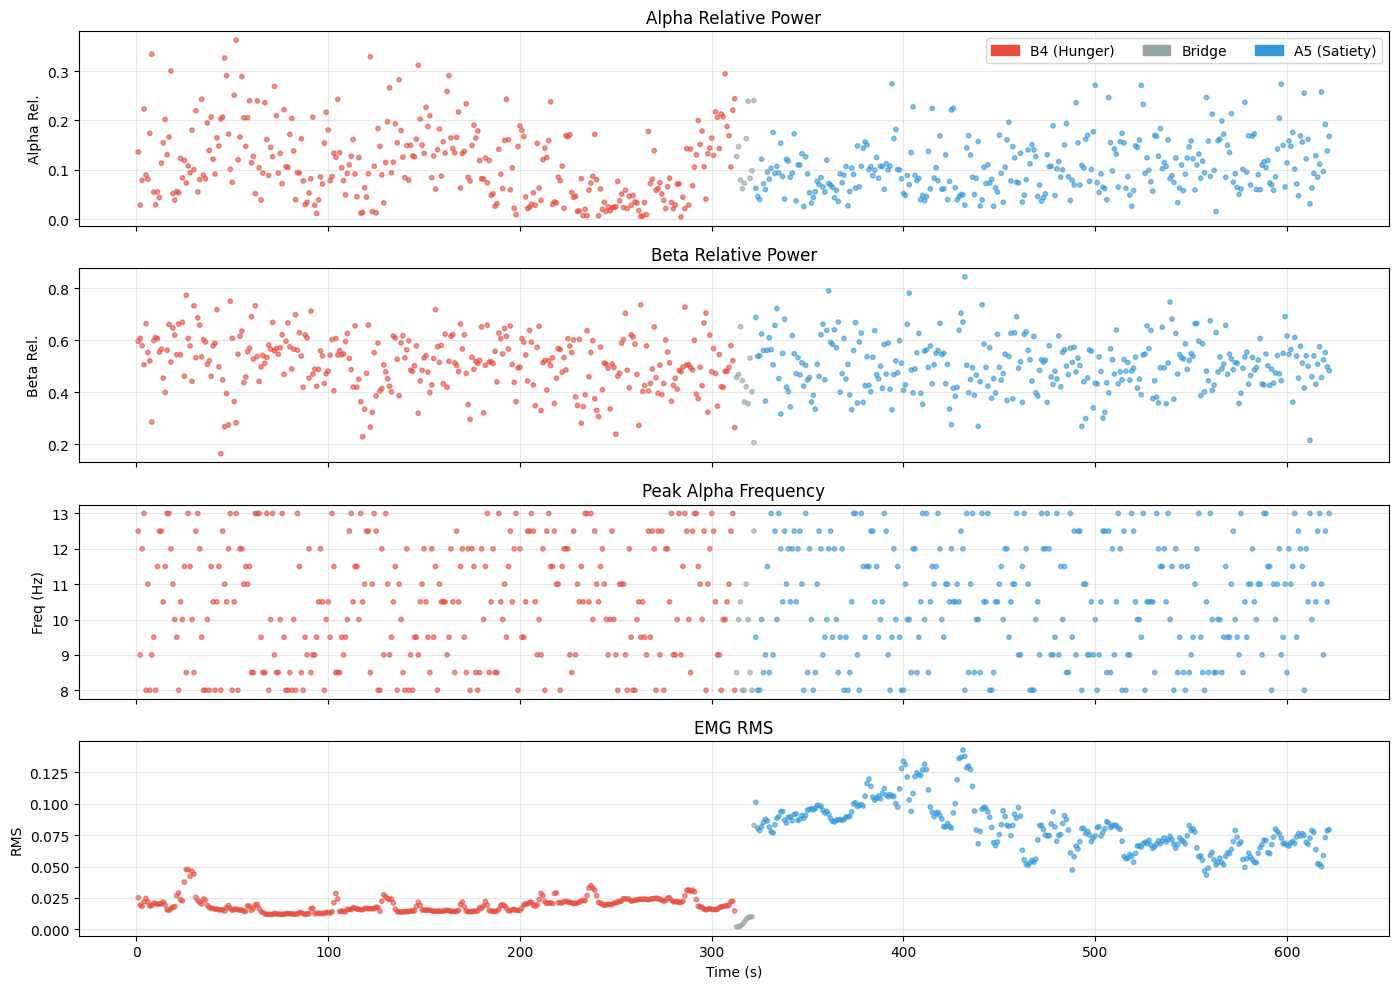


EXTRACTING FEATURES: Ayush
Features: 609 windows
Features: 609 windows


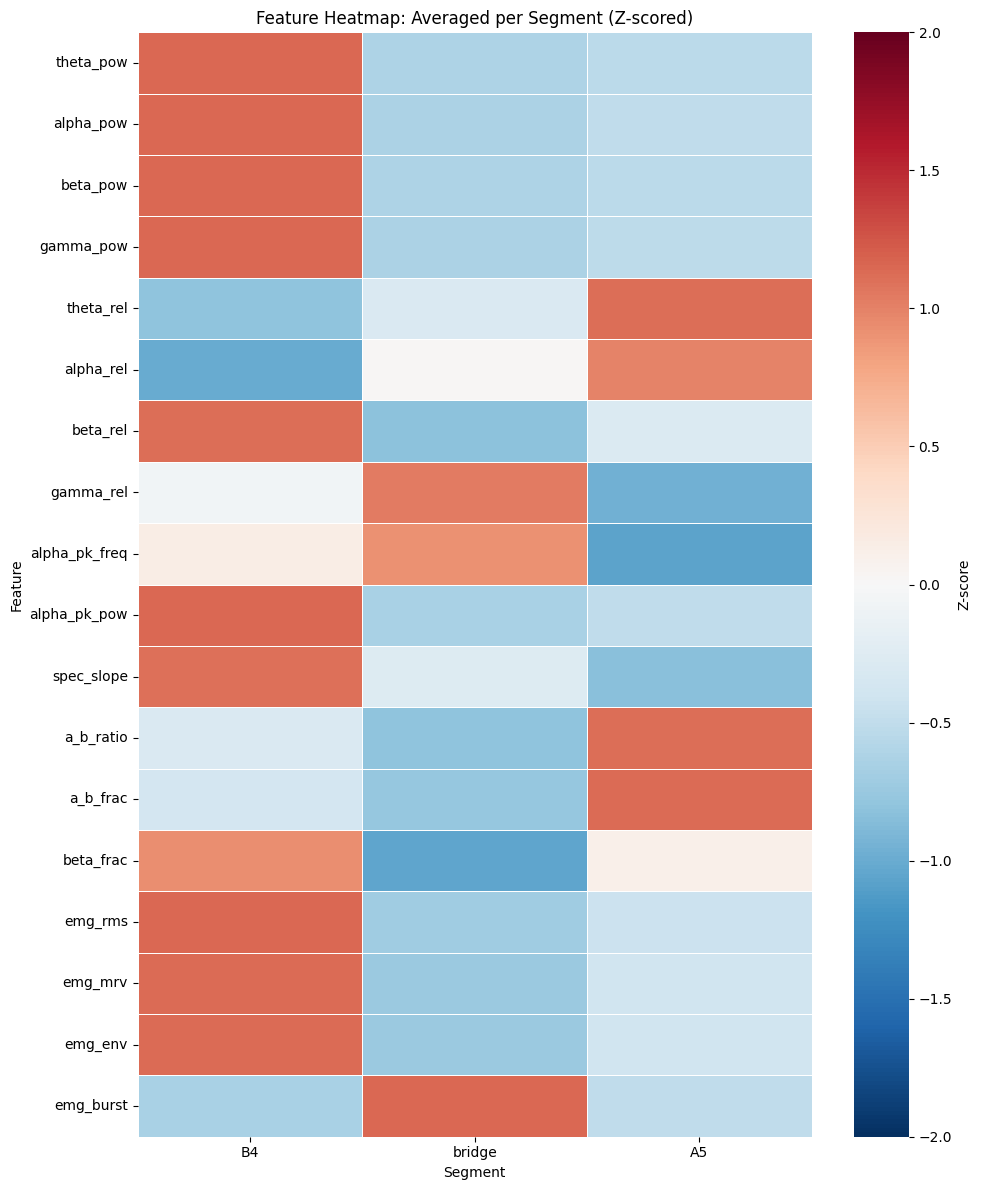

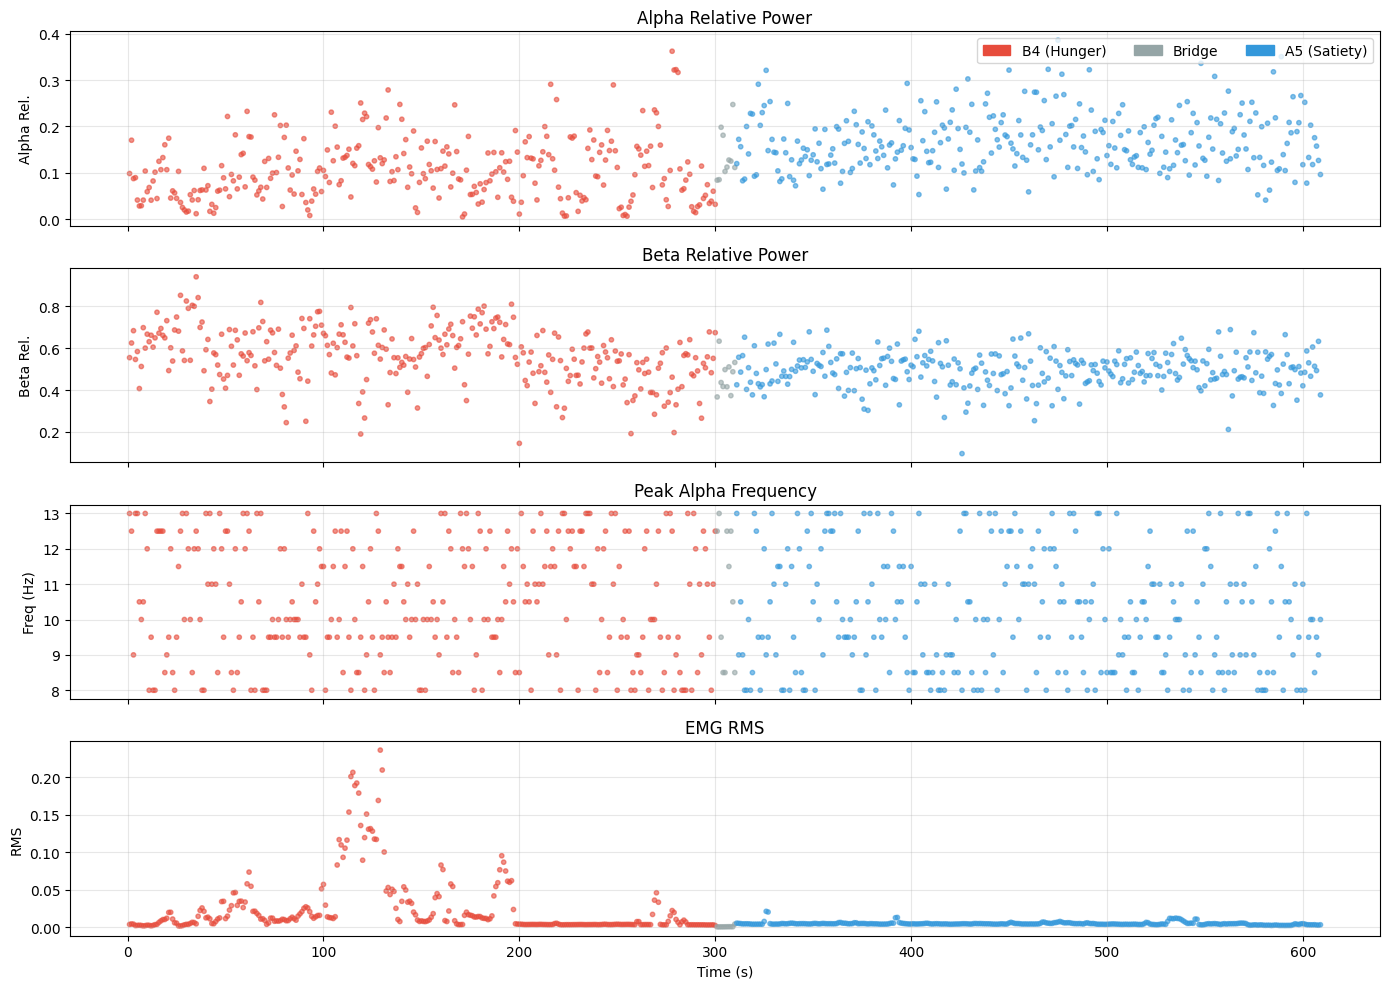


EXTRACTING FEATURES: Jay
Features: 609 windows
Features: 609 windows


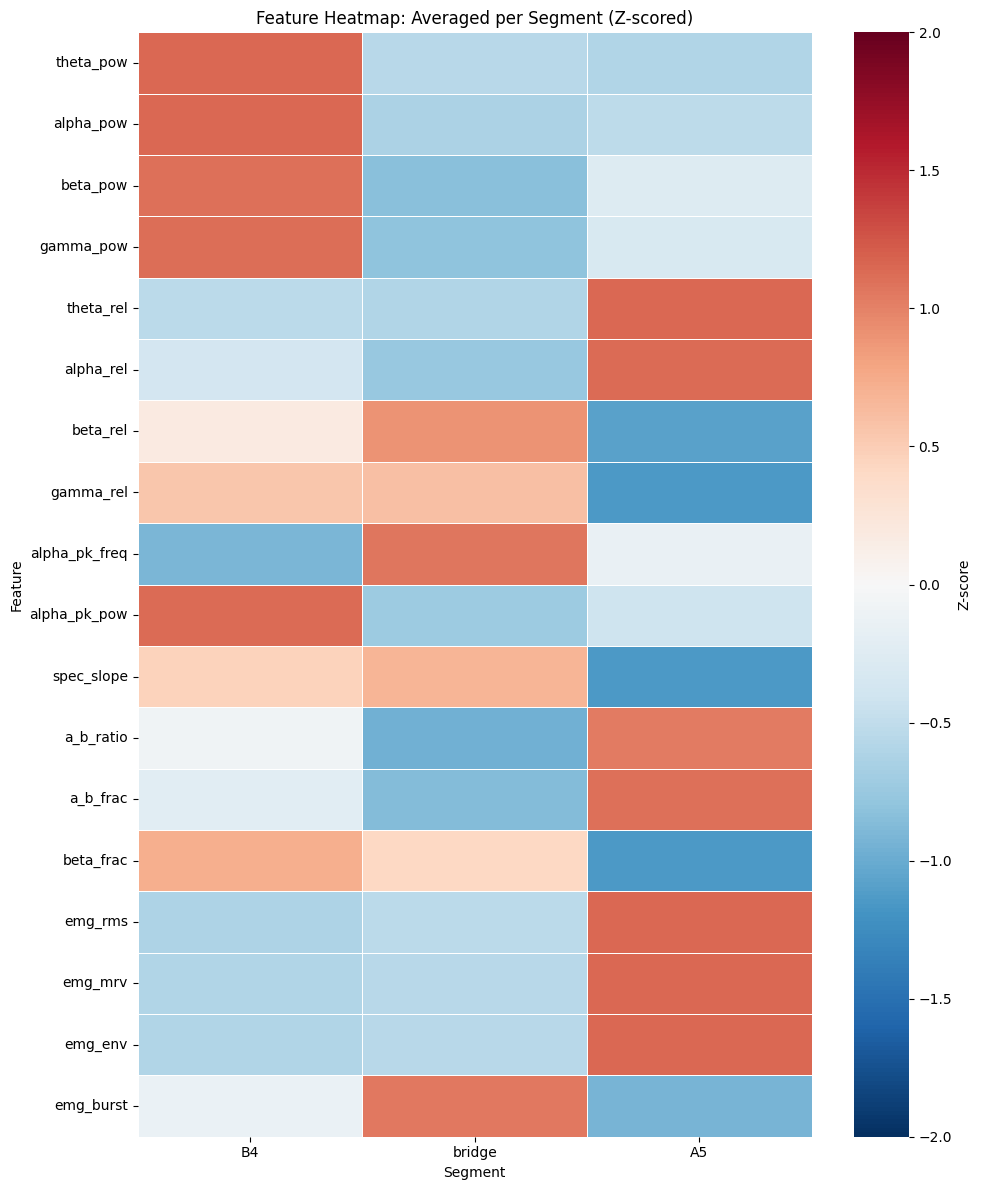

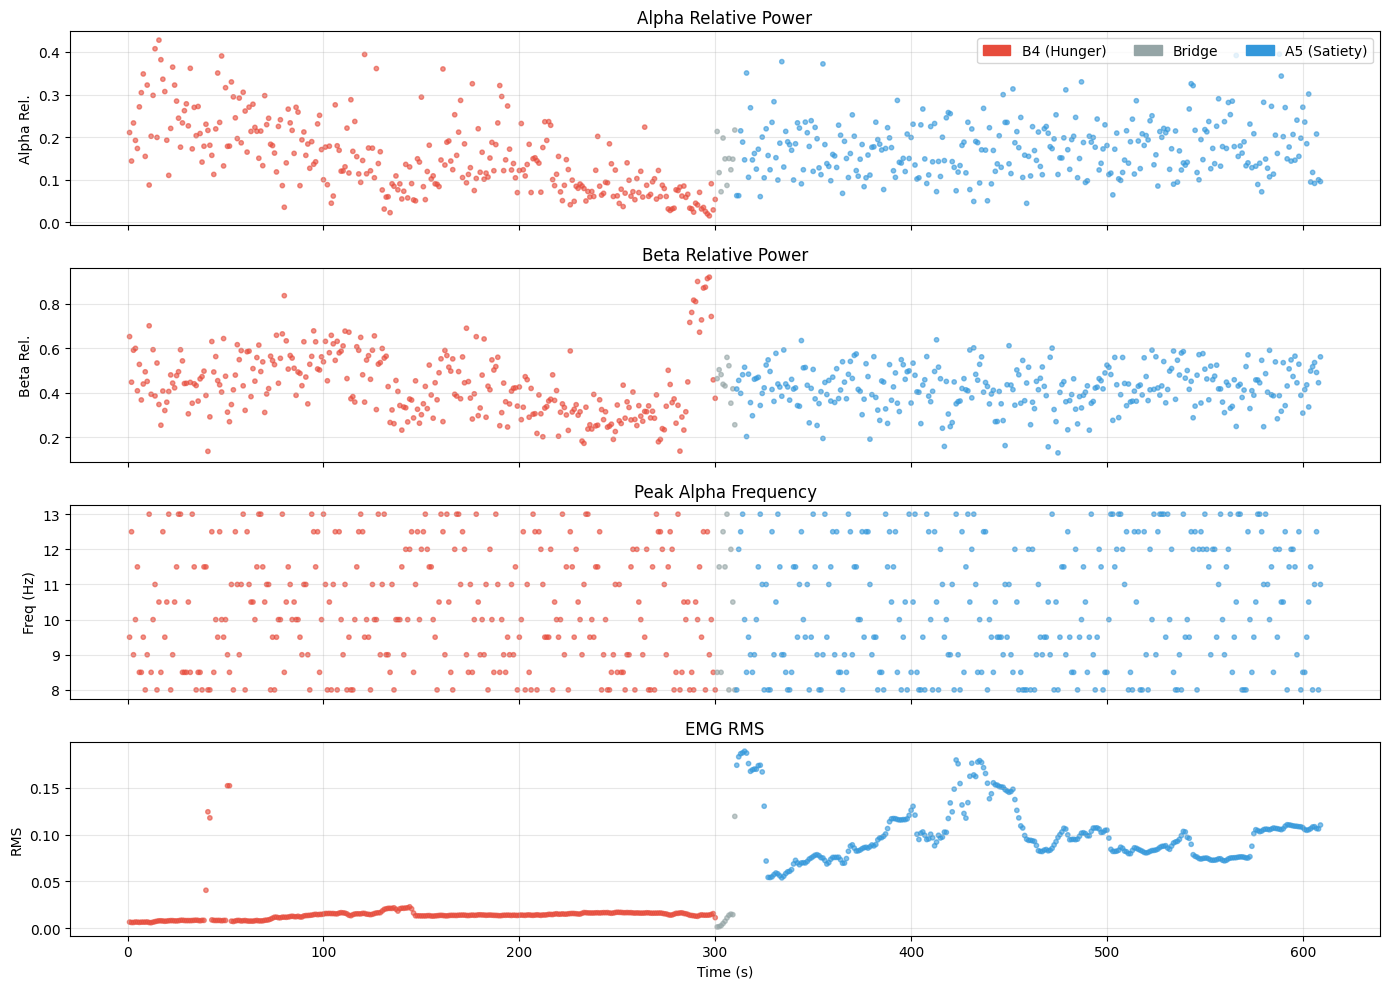



Feature extraction complete for 3 subjects


In [31]:
from modules.feature_extraction import extract_all_features, plot_feature_heatmap, plot_features_timeline
import matplotlib.pyplot as plt

# Store features for all subjects
features_data = {}

for name in combined_data.keys():
    print(f"\n{'='*70}")
    print(f"EXTRACTING FEATURES: {name}")
    print('='*70)
    
    combined = combined_data[name]
    
    features = extract_all_features(
        combined,
        cfg.fs,
        cfg.win_sec,
        cfg.step_sec
    )
    features_data[name] = features
    
    print(f"Features: {len(features)} windows")
    
    # Plot feature heatmap
    fig = plot_feature_heatmap(features)
    fig.savefig(f'output/{name}_feature_heatmap.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()
    
    # Plot feature timeline
    fig = plot_features_timeline(features)
    fig.savefig(f'output/{name}_feature_timeline.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()

print(f"\n\nFeature extraction complete for {len(features_data)} subjects")

## Step 3: Feature Extraction

Extract EEG spectral features and EMG time-domain features


BUILDING HUNGER INDEX: Bhargavi


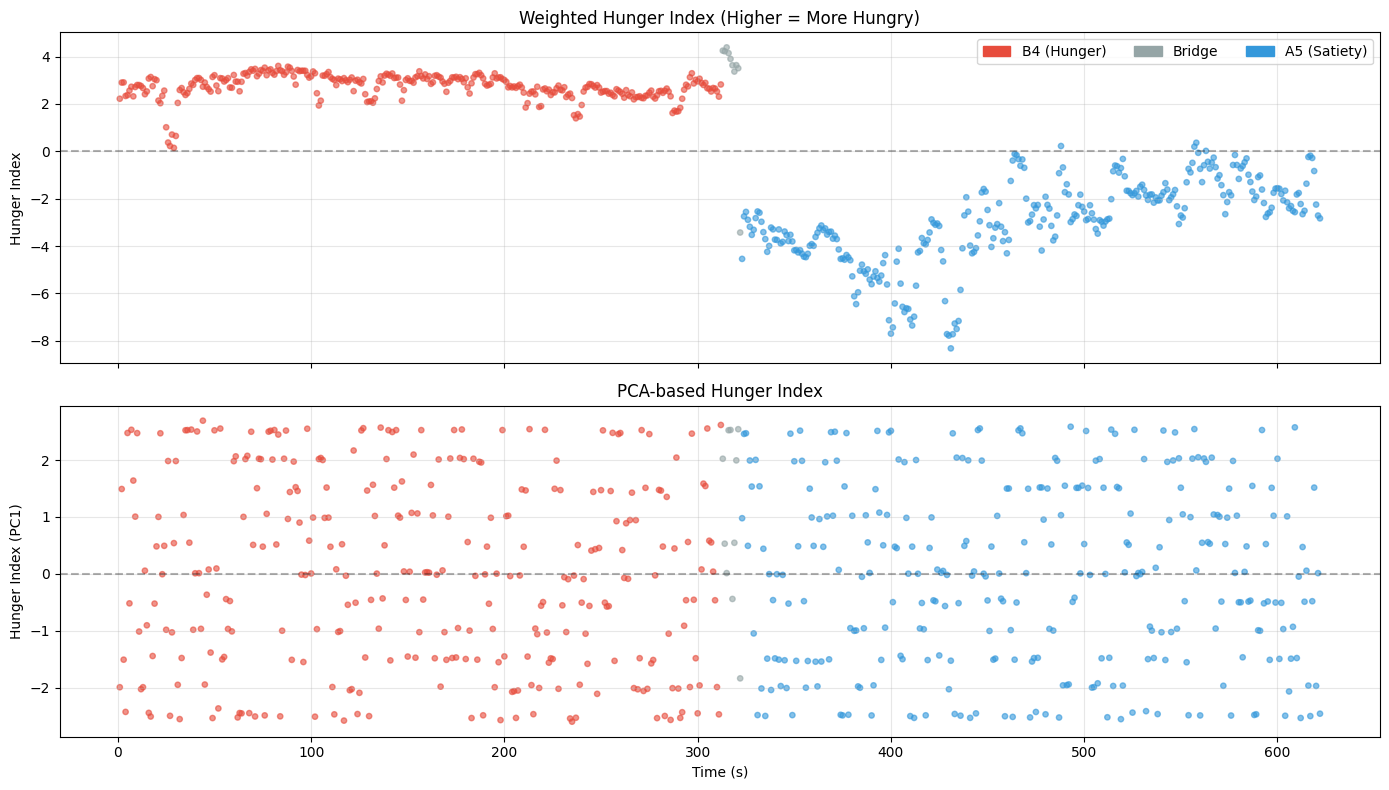


BUILDING HUNGER INDEX: Ayush


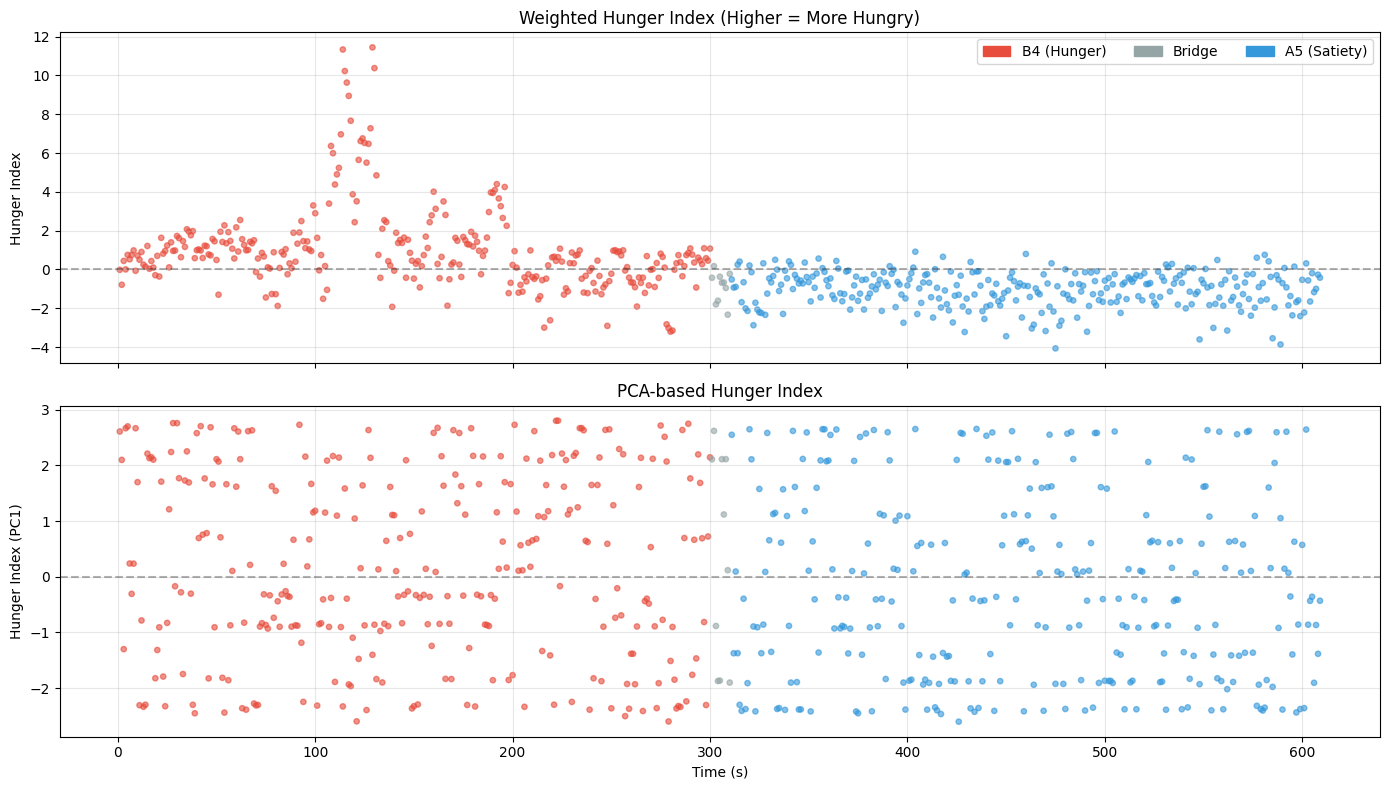


BUILDING HUNGER INDEX: Jay


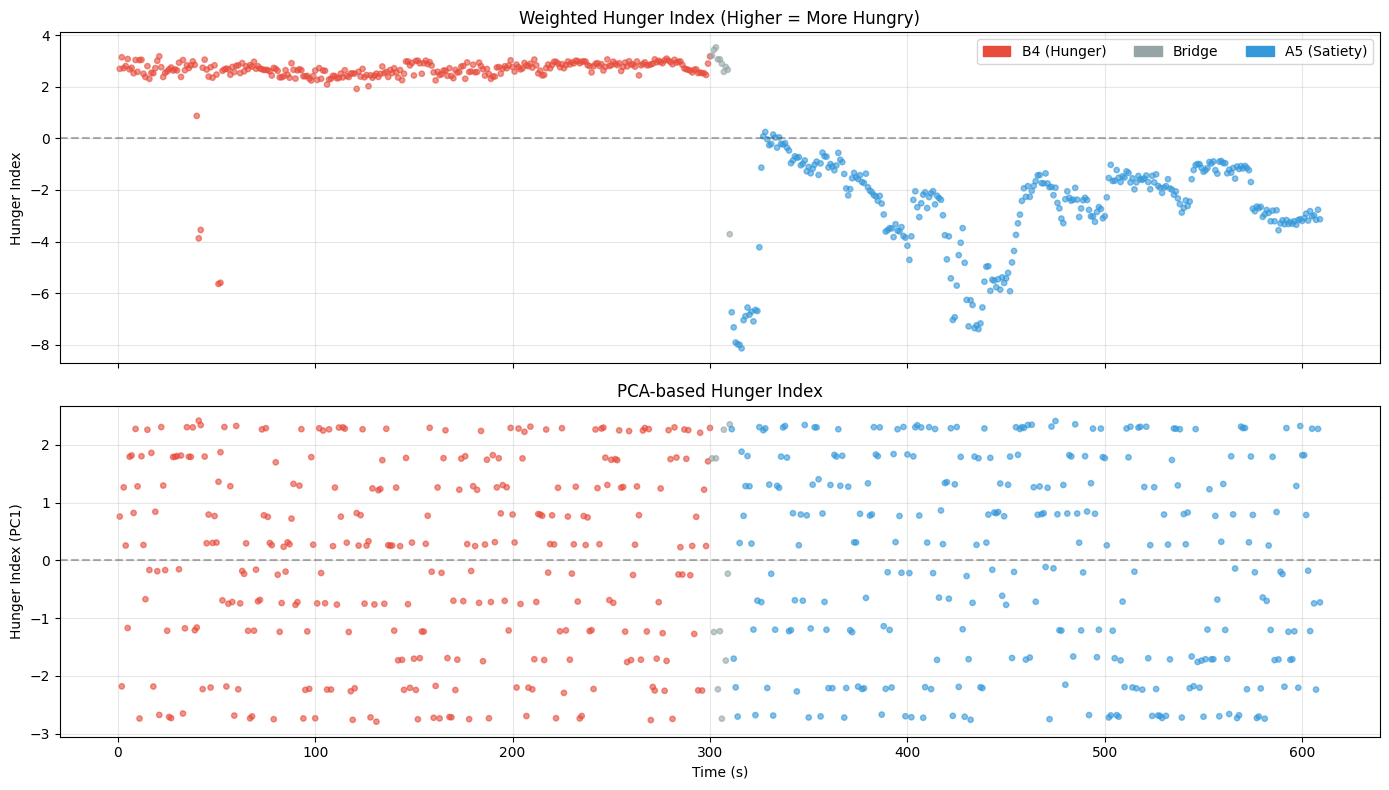



Hunger index construction complete for 3 subjects


In [32]:
from modules.hunger_index import build_hunger_index_weighted, build_hunger_index_pca, plot_hunger_indices
import matplotlib.pyplot as plt

# Store hunger indices
hunger_indices = {}

for name in features_data.keys():
    print(f"\n{'='*70}")
    print(f"BUILDING HUNGER INDEX: {name}")
    print('='*70)
    
    features = features_data[name]
    
    # Build both weighted and PCA indices (use default weights)
    idx_weighted = build_hunger_index_weighted(features)
    idx_pca = build_hunger_index_pca(features)
    t = features['time'].values  # Already in seconds from features
    
    hunger_indices[name] = {
        'weighted': idx_weighted,
        'pca': idx_pca,
        'time': t,
        'segments': features['segment'].values
    }
    
    # Plot both indices
    fig = plot_hunger_indices(features, idx_weighted, idx_pca)
    plt.tight_layout()
    plt.savefig(f'output/{name}_hunger_indices.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()

print(f"\n\nHunger index construction complete for {len(hunger_indices)} subjects")

In [33]:
# Verify the hunger index direction is now consistent
print("\n" + "="*70)
print("VERIFICATION: Hunger Index Direction")
print("="*70)

for name, hi in hunger_indices.items():
    b4_mean = hi['weighted'][hi['segments'] == 'B4'].mean()
    a5_mean = hi['weighted'][hi['segments'] == 'A5'].mean()
    
    print(f"\n{name}:")
    print(f"  B4 (Hunger) Mean: {b4_mean:+.2f}")
    print(f"  A5 (Satiety) Mean: {a5_mean:+.2f}")
    print(f"  Difference (B4-A5): {b4_mean - a5_mean:+.2f}")
    print(f"  ✓ Consistent!" if b4_mean > a5_mean else "  ✗ Flipped!")


VERIFICATION: Hunger Index Direction

Bhargavi:
  B4 (Hunger) Mean: +2.74
  A5 (Satiety) Mean: -2.95
  Difference (B4-A5): +5.69
  ✓ Consistent!

Ayush:
  B4 (Hunger) Mean: +1.06
  A5 (Satiety) Mean: -1.03
  Difference (B4-A5): +2.09
  ✓ Consistent!

Jay:
  B4 (Hunger) Mean: +2.58
  A5 (Satiety) Mean: -2.67
  Difference (B4-A5): +5.25
  ✓ Consistent!


## Step 4: Hunger Index Construction

Build weighted and PCA-based hunger indices

In [34]:
from modules.hunger_index import fit_polynomial, compute_derivatives, plot_polynomial_fit
print("Polynomial functions imported")

Polynomial functions imported


In [35]:
print("\n" + "="*70 + "\nFITTING POLYNOMIAL: Bhargavi\n" + "="*70)
polynomial_data = {}

for name, hi in hunger_indices.items():
    print(f"\nSubject: {name}")
    t = hi['time']
    idx_weighted = hi['weighted']
    idx_pca = hi['pca']

    # Fit polynomial (returns coeffs, fitted, poly)
    coef_w, fitted_w, poly_w = fit_polynomial(t, idx_weighted, deg=5)
    d1_w, d2_w = compute_derivatives(t, poly_w)

    coef_p, fitted_p, poly_p = fit_polynomial(t, idx_pca, deg=5)
    d1_p, d2_p = compute_derivatives(t, poly_p)

    polynomial_data[name] = {
        'coef_weighted': coef_w,
        'fitted_weighted': fitted_w,
        'poly_weighted': poly_w,
        'deriv1_weighted': d1_w,
        'deriv2_weighted': d2_w,
        'coef_pca': coef_p,
        'fitted_pca': fitted_p,
        'poly_pca': poly_p,
        'deriv1_pca': d1_p,
        'deriv2_pca': d2_p,
    }

print("\nPolynomial fitting and derivative computation complete for", len(polynomial_data), "subjects")


FITTING POLYNOMIAL: Bhargavi

Subject: Bhargavi

Subject: Ayush

Subject: Jay

Polynomial fitting and derivative computation complete for 3 subjects


## Step 5: Polynomial Fitting and Derivative Analysis

Fit 5th-degree polynomial and compute derivatives


DETECTING BREAKPOINTS: Bhargavi

Subject: Bhargavi


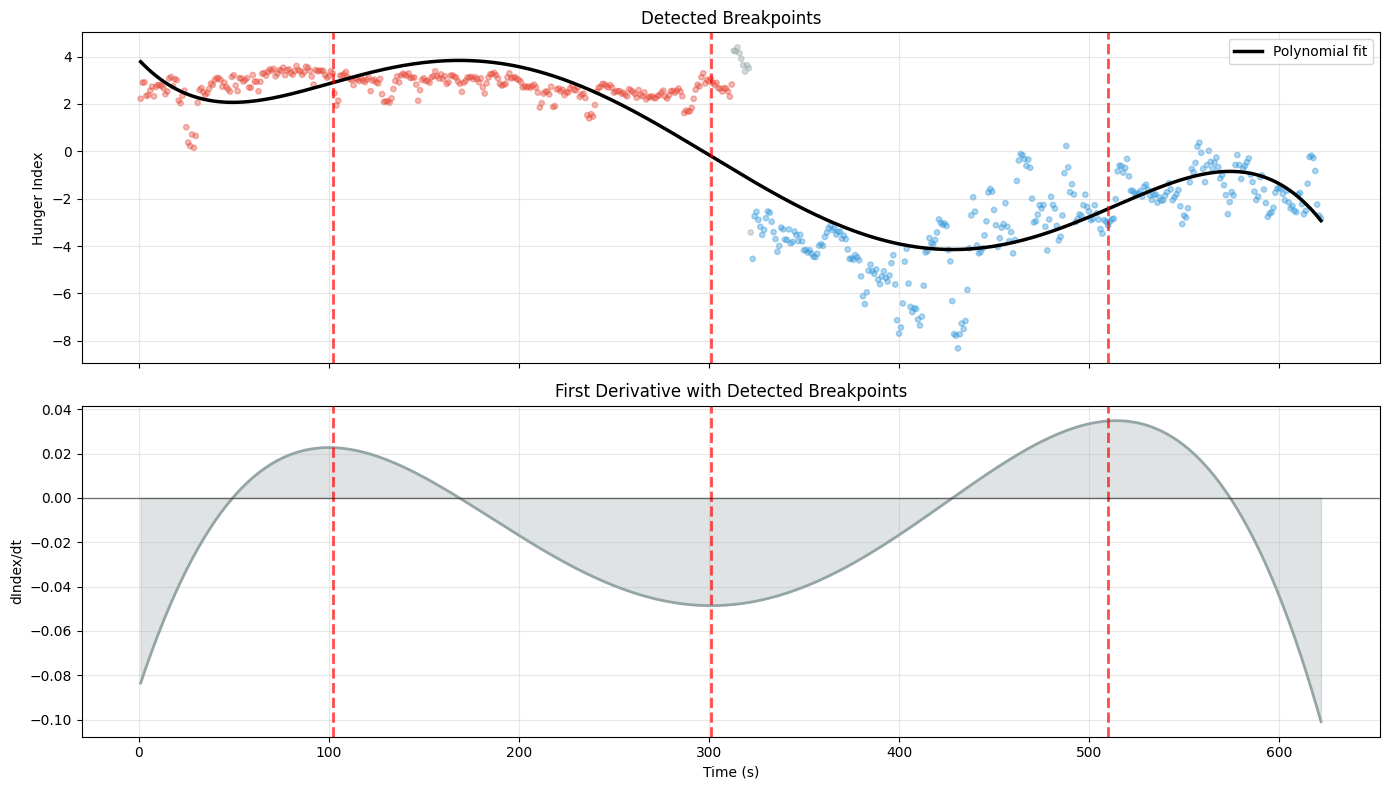


Subject: Ayush


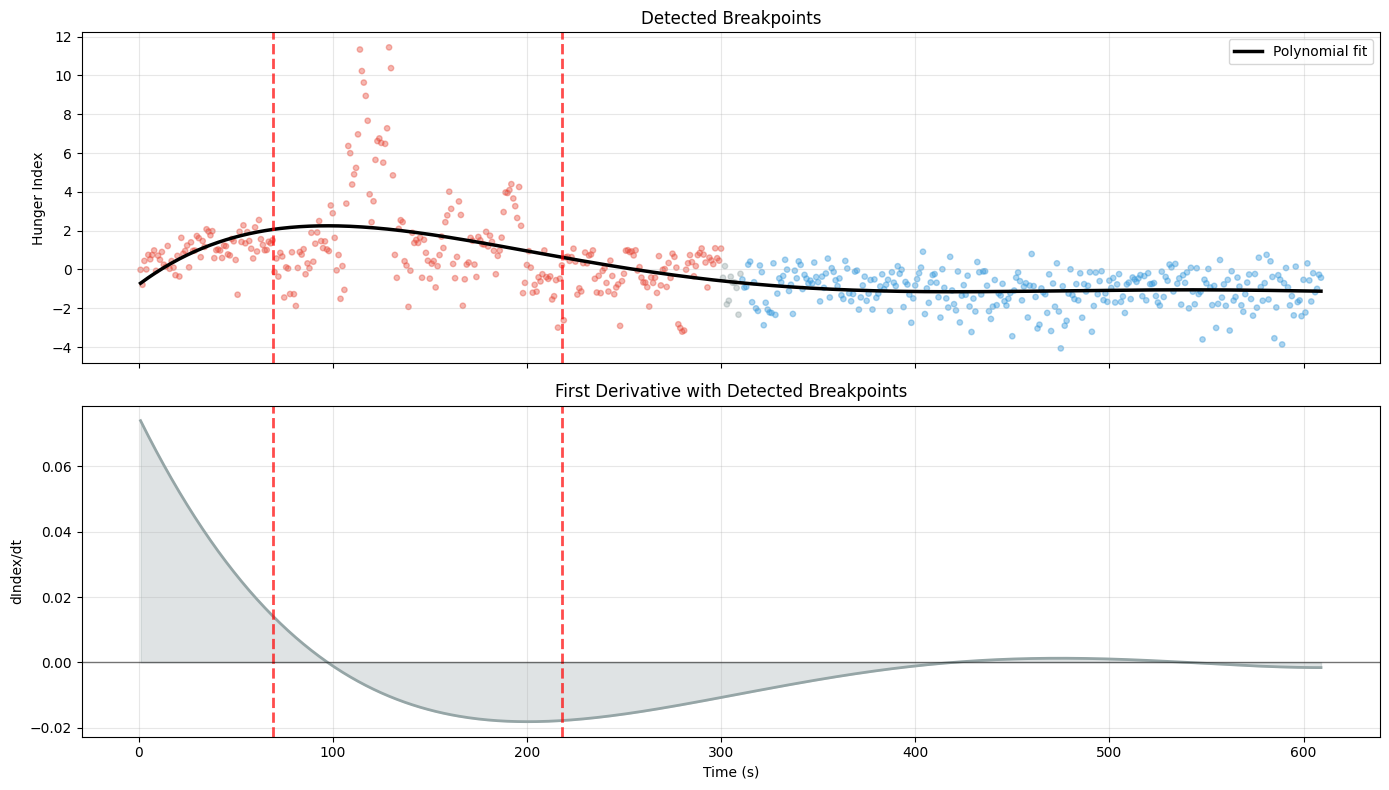


Subject: Jay


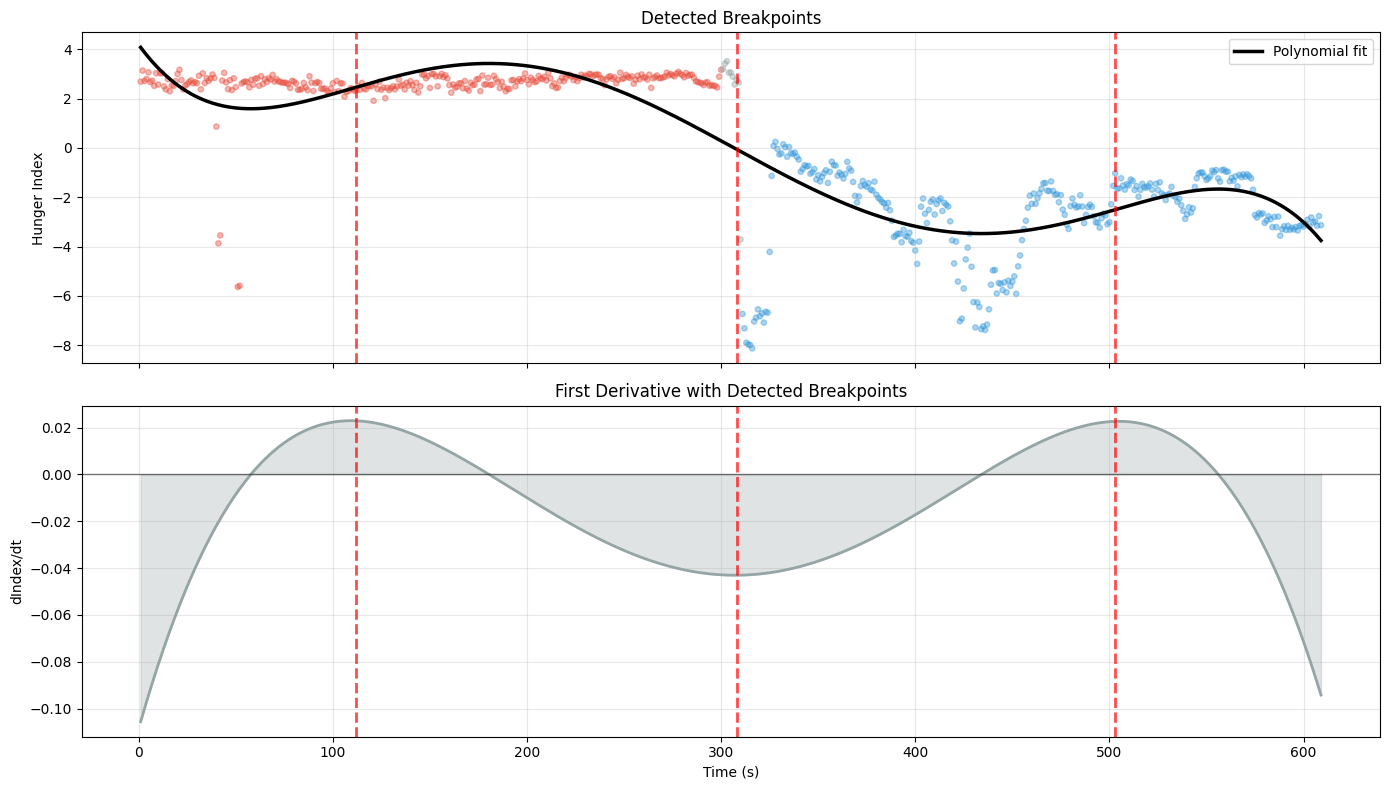


Breakpoint detection complete for 3 subjects


In [36]:
from modules.hunger_index import detect_breakpoints_derivative, plot_breakpoints

print("\n" + "="*70 + "\nDETECTING BREAKPOINTS: Bhargavi\n" + "="*70)

breakpoints_data = {}

for name in hunger_indices.keys():
    print(f"\nSubject: {name}")
    t = hunger_indices[name]['time']
    idx_weighted = hunger_indices[name]['weighted']
    segments = features_data[name]['segment'] if name in features_data else features['segment'].values

    poly = polynomial_data[name]['poly_weighted']
    fitted = polynomial_data[name]['fitted_weighted']
    deriv1 = polynomial_data[name]['deriv1_weighted']
    deriv2 = polynomial_data[name]['deriv2_weighted']

    # Detect breakpoints using improved derivative-based method
    # Added smoothing (window=30) and edge constraints (margin=10%)
    bkpts_deriv = detect_breakpoints_derivative(t, deriv1, deriv2, 
                                                threshold_factor=1.5,
                                                smooth_window=30,
                                                edge_margin=0.1)

    breakpoints_data[name] = {
        'bkpts_deriv': bkpts_deriv,
    }

    # Plot visualization
    fig = plot_breakpoints(t, idx_weighted, fitted, deriv1, bkpts_deriv, segments)
    fig.savefig(f'output/{name}_breakpoints.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()
    plt.close(fig)

print("\nBreakpoint detection complete for", len(breakpoints_data), "subjects")

## Step 6: Breakpoint Detection

Detect transition points using derivative-based method


TRAINING MODELS: Bhargavi
Train: 489 samples, Test: 123 samples
Using reduced features: alpha_rel, beta_rel, emg_rms


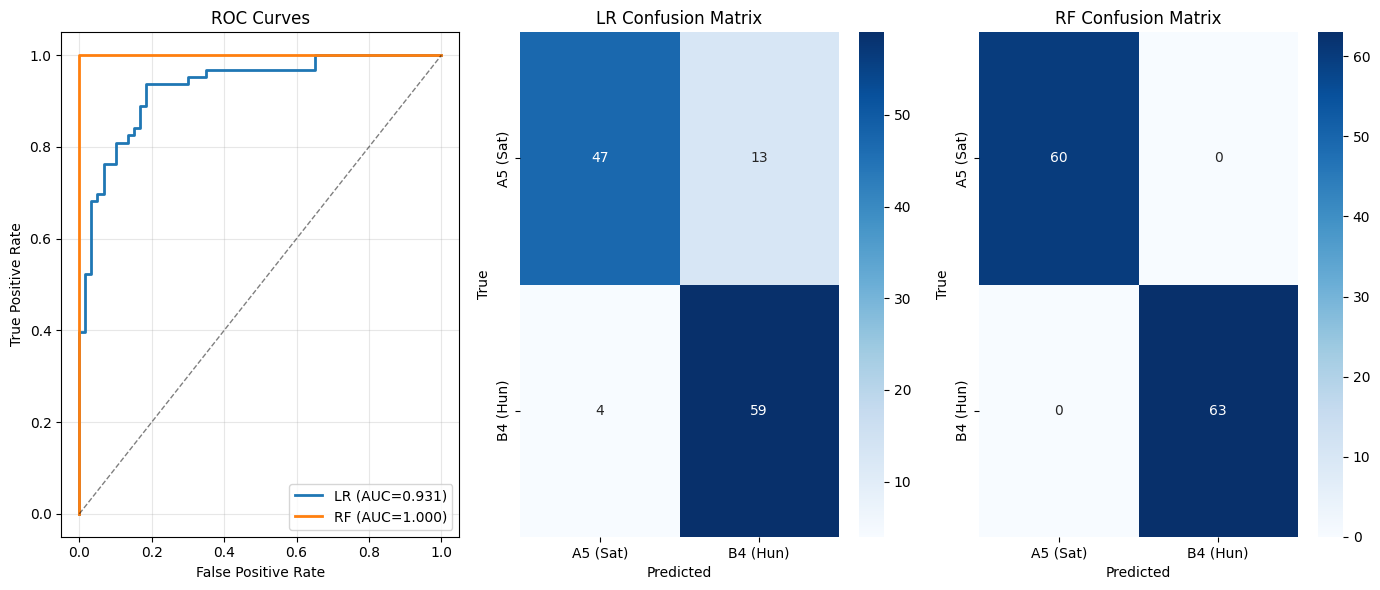


MODEL PERFORMANCE METRICS

LR:
  Accuracy:  0.862
  Precision: 0.819
  Recall:    0.937
  F1-Score:  0.874
  ROC-AUC:   0.931

RF:
  Accuracy:  1.000
  Precision: 1.000
  Recall:    1.000
  F1-Score:  1.000
  ROC-AUC:   1.000


TRAINING MODELS: Ayush
Train: 479 samples, Test: 120 samples
Using reduced features: alpha_rel, beta_rel, emg_rms


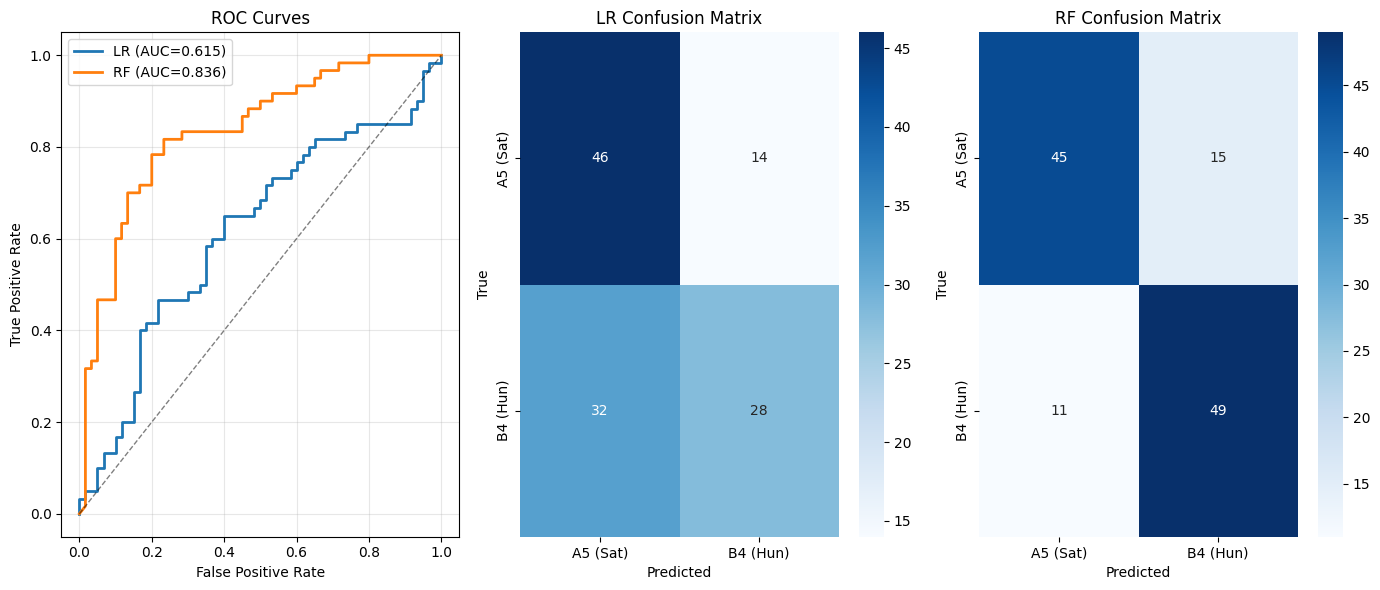


MODEL PERFORMANCE METRICS

LR:
  Accuracy:  0.617
  Precision: 0.667
  Recall:    0.467
  F1-Score:  0.549
  ROC-AUC:   0.615

RF:
  Accuracy:  0.783
  Precision: 0.766
  Recall:    0.817
  F1-Score:  0.790
  ROC-AUC:   0.836


TRAINING MODELS: Jay
Train: 479 samples, Test: 120 samples
Using reduced features: alpha_rel, beta_rel, emg_rms


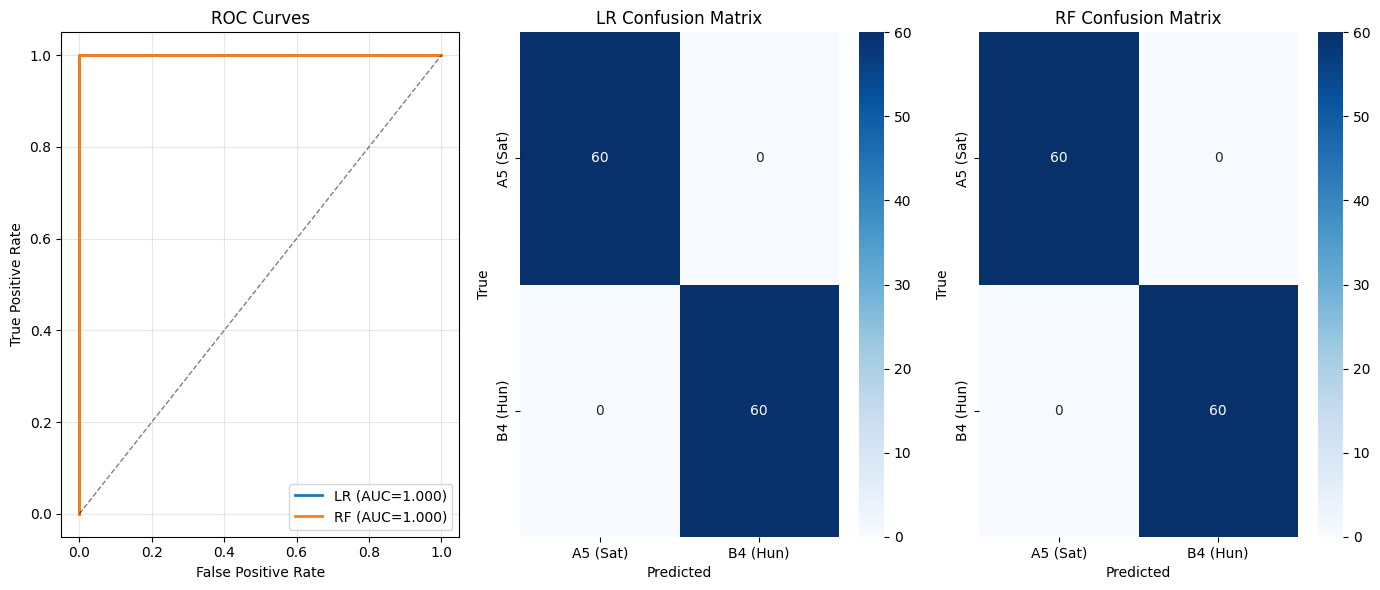


MODEL PERFORMANCE METRICS

LR:
  Accuracy:  1.000
  Precision: 1.000
  Recall:    1.000
  F1-Score:  1.000
  ROC-AUC:   1.000

RF:
  Accuracy:  1.000
  Precision: 1.000
  Recall:    1.000
  F1-Score:  1.000
  ROC-AUC:   1.000



Model training complete for 3 subjects


In [37]:
from modules.classification import build_feature_matrix_labels, train_models, plot_model_performance
from sklearn.model_selection import train_test_split

# Store classification models
models_data = {}

for name in features_data.keys():
    print(f"\n{'='*70}")
    print(f"TRAINING MODELS: {name}")
    print('='*70)
    
    features = features_data[name]
    
    # Build feature matrix with reduced features to prevent overfitting
    from modules.classification import time_series_split
    
    X, y = build_feature_matrix_labels(features, use_reduced_features=True)
    
    # Use time-series split instead of random split
    feat_df_filtered = features[features['segment'].isin(['B4', 'A5'])].copy()
    X_train, X_test, y_train, y_test = time_series_split(X, y, feat_df_filtered, test_ratio=0.2)
    
    print(f"Train: {len(X_train)} samples, Test: {len(X_test)} samples")
    print(f"Using reduced features: alpha_rel, beta_rel, emg_rms")
    
    # Train models
    results = train_models(X_train, y_train, X_test, y_test)
    
    models_data[name] = {
        'results': results,
        'X_test': X_test,
        'y_test': y_test
    }
    
    # Plot model performance
    fig = plot_model_performance(y_test, results)
    fig.savefig(f'output/{name}_model_performance.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    # Print metrics
    print("\n" + "="*60)
    print("MODEL PERFORMANCE METRICS")
    print("="*60)
    for model_name, model_metrics in results.items():
        print(f"\n{model_name.upper()}:")
        print(f"  Accuracy:  {model_metrics['accuracy']:.3f}")
        print(f"  Precision: {model_metrics['precision']:.3f}")
        print(f"  Recall:    {model_metrics['recall']:.3f}")
        print(f"  F1-Score:  {model_metrics['f1']:.3f}")
        print(f"  ROC-AUC:   {model_metrics['roc_auc']:.3f}")
    print("="*60 + "\n")

print(f"\n\nModel training complete for {len(models_data)} subjects")

## Step 7: Classification Model Training

Train Logistic Regression and Random Forest models


GENERATING PREDICTIONS: Bhargavi


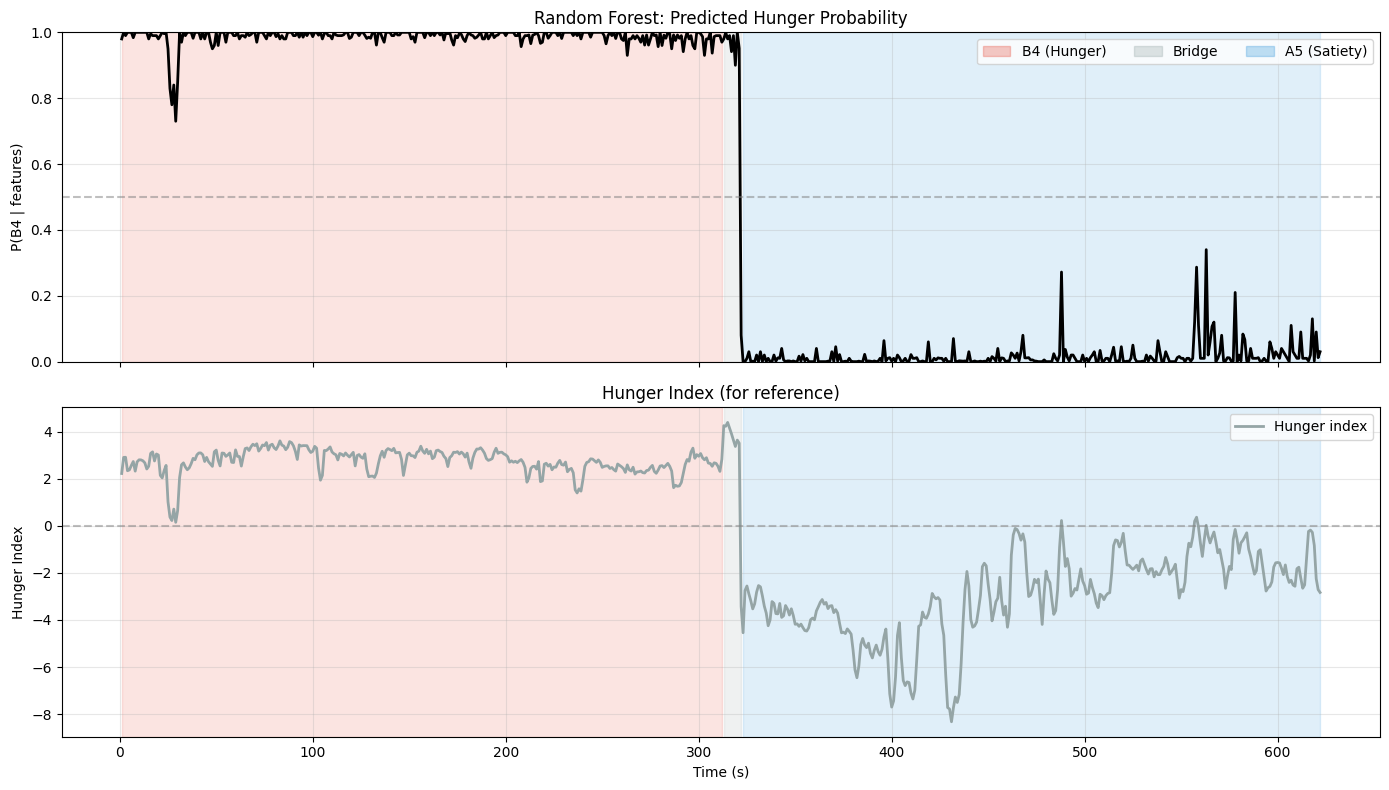

  → Saved: output/Bhargavi_prediction_timeline_rf.png

GENERATING PREDICTIONS: Ayush


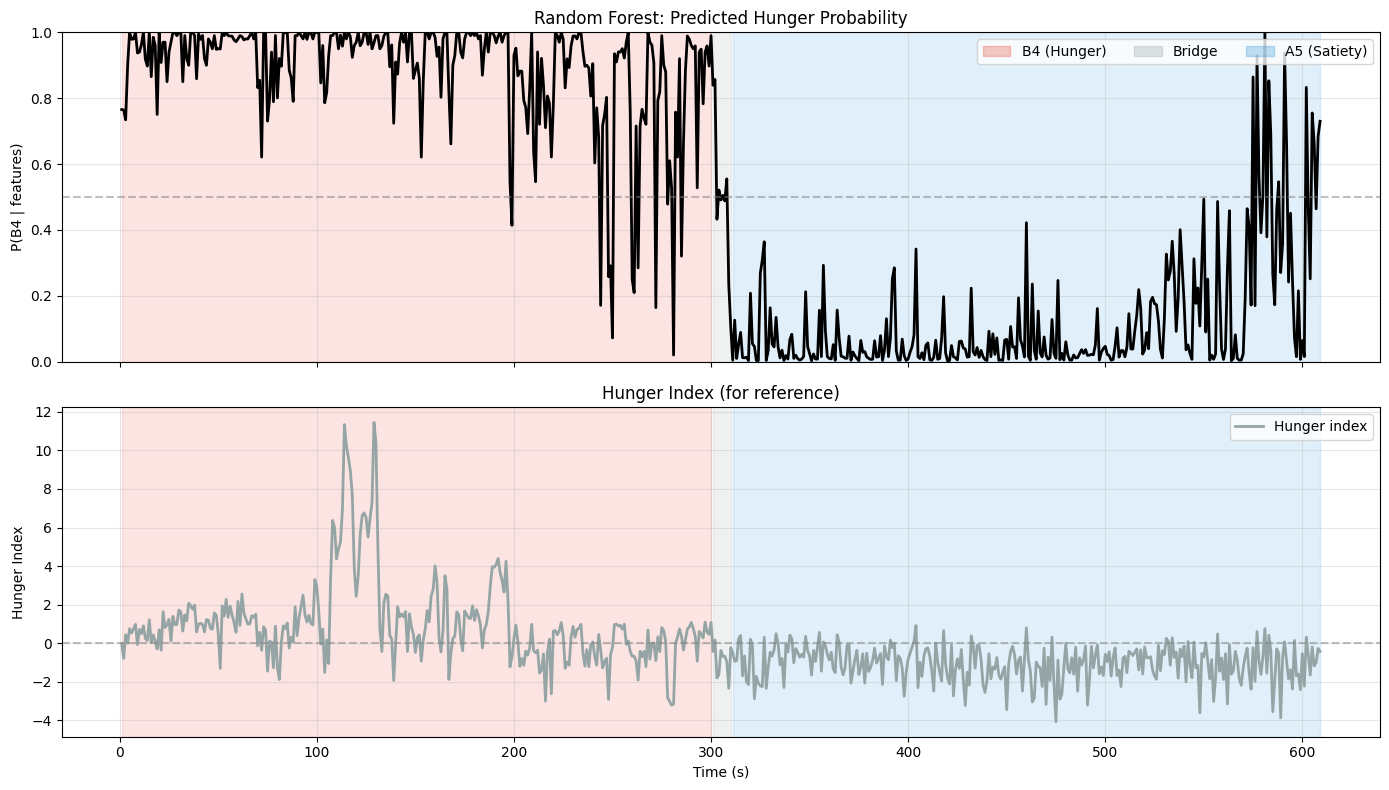

  → Saved: output/Ayush_prediction_timeline_rf.png

GENERATING PREDICTIONS: Jay


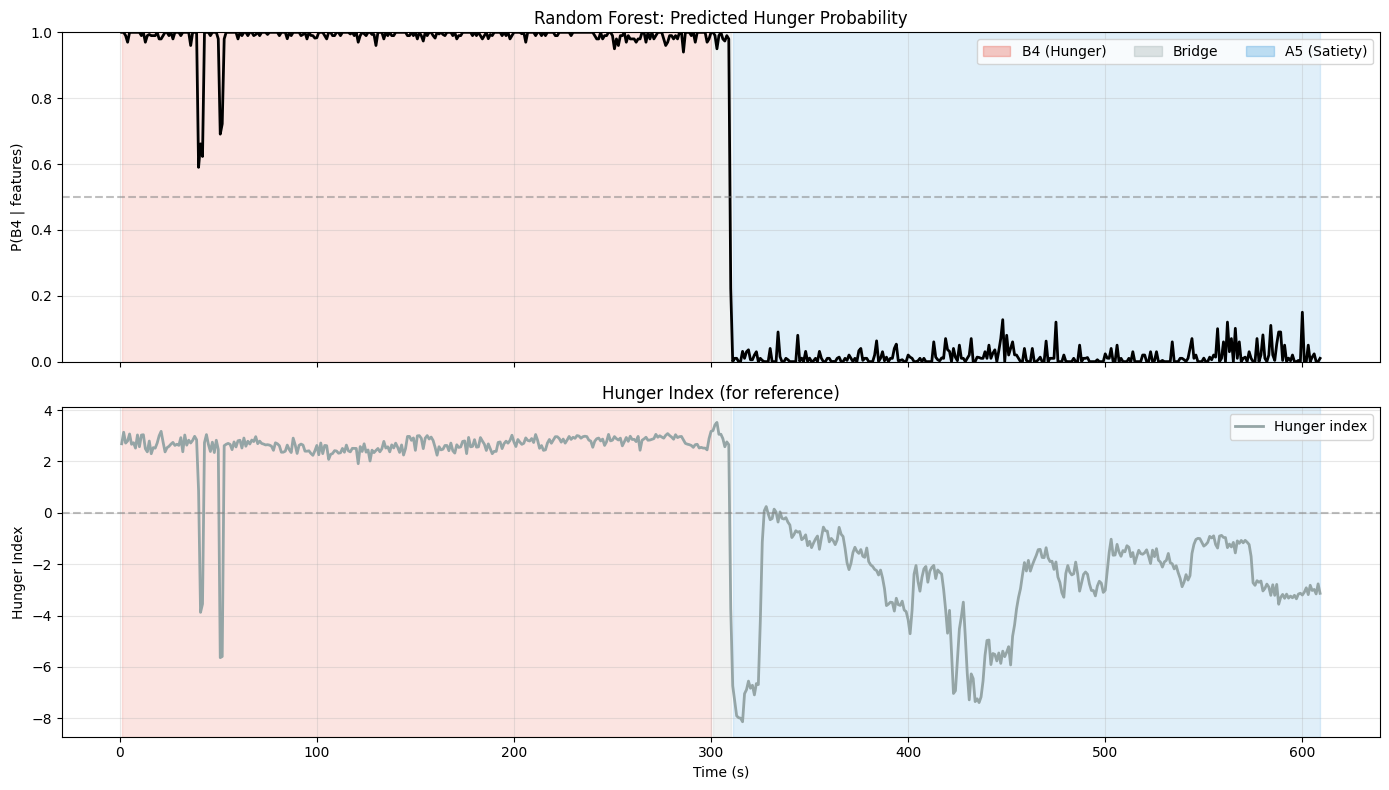

  → Saved: output/Jay_prediction_timeline_rf.png


Prediction visualization complete for 3 subjects


In [38]:
from modules.classification import predict_hunger_proba, plot_prediction_timeline

for name in models_data.keys():
    print(f"\n{'='*70}")
    print(f"GENERATING PREDICTIONS: {name}")
    print('='*70)
    
    features = features_data[name]
    results = models_data[name]['results']
    idx_weighted = hunger_indices[name]['weighted']
    
    # Generate predictions using Random Forest model
    rf_model = results['rf']['model']
    proba_rf = predict_hunger_proba(rf_model, features, use_reduced_features=True)
    
    # Plot prediction timeline
    fig = plot_prediction_timeline(features, proba_rf, idx_weighted, model_name='Random Forest', show=False)
    fig.savefig(f'output/{name}_prediction_timeline_rf.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    print(f"  → Saved: output/{name}_prediction_timeline_rf.png")

print(f"\n\nPrediction visualization complete for {len(models_data)} subjects")

## Step 8: Prediction Timeline Visualization

Generate hunger probability predictions over time

In [39]:
import json
import os

# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)

# Compile and export results for all subjects
all_summaries = {}

for name in valid_subjects.keys():
    print(f"\n{'='*70}")
    print(f"EXPORTING RESULTS: {name}")
    print('='*70)
    
    features = features_data[name]
    idx_weighted = hunger_indices[name]['weighted']
    bkpts_deriv = breakpoints_data[name]['bkpts_deriv']
    results = models_data[name]['results']
    
    # Count windows per segment
    b4_count = (features['segment'] == 'B4').sum()
    bridge_count = (features['segment'] == 'bridge').sum()
    a5_count = (features['segment'] == 'A5').sum()
    
    # Calculate hunger index statistics
    b4_mask = features['segment'] == 'B4'
    a5_mask = features['segment'] == 'A5'
    
    summary = {
        'subject': name,
        'dataset': {
            'b4_windows': int(b4_count),
            'bridge_windows': int(bridge_count),
            'a5_windows': int(a5_count),
            'total_windows': len(features)
        },
        'hunger_index': {
            'mean': float(idx_weighted.mean()),
            'std': float(idx_weighted.std()),
            'b4_mean': float(idx_weighted[b4_mask].mean()),
            'a5_mean': float(idx_weighted[a5_mask].mean())
        },
        'breakpoints': {
            'derivative_method': [float(bp) for bp in bkpts_deriv]
        },
        'classification': {
            model_name: {
                'accuracy': float(model_metrics['accuracy']),
                'roc_auc': float(model_metrics['roc_auc']),
                'f1_score': float(model_metrics['f1'])
            }
            for model_name, model_metrics in results.items()
        }
    }
    
    all_summaries[name] = summary
    
    # Print summary
    print("\nSUMMARY REPORT")
    print("="*70)
    print(f"\nSubject: {name}")
    print(f"\nDataset:")
    print(f"  B4 windows:     {b4_count}")
    print(f"  Bridge windows: {bridge_count}")
    print(f"  A5 windows:     {a5_count}")
    print(f"  Total windows:  {len(features)}")
    print(f"\nHunger Index (Weighted):")
    print(f"  Mean: {idx_weighted.mean():.3f}")
    print(f"  Std:  {idx_weighted.std():.3f}")
    print(f"  B4 mean:  {idx_weighted[b4_mask].mean():.3f}")
    print(f"  A5 mean:  {idx_weighted[a5_mask].mean():.3f}")
    print(f"\nDetected Breakpoints (Derivative Method):")
    for i, bp in enumerate(bkpts_deriv, 1):
        print(f"  Breakpoint {i}: {bp:.2f} sec")
    print(f"\nClassification Performance:")
    for model_name, model_metrics in results.items():
        print(f"  {model_name}:")
        print(f"    Accuracy:  {model_metrics['accuracy']:.3f}")
        print(f"    ROC-AUC:   {model_metrics['roc_auc']:.3f}")
        print(f"    F1-Score:  {model_metrics['f1']:.3f}")
    print("="*70)
    
    # Export features to CSV
    features.to_csv(f'output/{name}_features.csv', index=False)
    print(f"\nFeatures exported to: output/{name}_features.csv")
    
    # Export summary to JSON
    with open(f'output/{name}_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"Summary exported to: output/{name}_summary.json")

# Export combined summary for all subjects
with open('output/all_subjects_summary.json', 'w') as f:
    json.dump(all_summaries, f, indent=2)

print(f"\n\n{'='*70}")
print("ALL RESULTS EXPORTED SUCCESSFULLY")
print('='*70)
print(f"Total subjects processed: {len(all_summaries)}")
print(f"Output directory: output/")
print(f"Combined summary: output/all_subjects_summary.json")


EXPORTING RESULTS: Bhargavi

SUMMARY REPORT

Subject: Bhargavi

Dataset:
  B4 windows:     312
  Bridge windows: 10
  A5 windows:     300
  Total windows:  622

Hunger Index (Weighted):
  Mean: -0.000
  Std:  3.139
  B4 mean:  2.736
  A5 mean:  -2.951

Detected Breakpoints (Derivative Method):
  Breakpoint 1: 102.00 sec
  Breakpoint 2: 301.00 sec
  Breakpoint 3: 510.00 sec

Classification Performance:
  lr:
    Accuracy:  0.862
    ROC-AUC:   0.931
    F1-Score:  0.874
  rf:
    Accuracy:  1.000
    ROC-AUC:   1.000
    F1-Score:  1.000

Features exported to: output/Bhargavi_features.csv
Summary exported to: output/Bhargavi_summary.json

EXPORTING RESULTS: Ayush

SUMMARY REPORT

Subject: Ayush

Dataset:
  B4 windows:     300
  Bridge windows: 10
  A5 windows:     299
  Total windows:  609

Hunger Index (Weighted):
  Mean: 0.000
  Std:  1.982
  B4 mean:  1.058
  A5 mean:  -1.032

Detected Breakpoints (Derivative Method):
  Breakpoint 1: 69.00 sec
  Breakpoint 2: 218.00 sec

Classificat